In [1]:
# %matplotlib notebook
# import mpld3
# mpld3.enable_notebook()
import os
from pathlib import Path
import sys

if not 'workbookDir' in globals():
    workbookDir = os.getcwd()
print('workbookDir: ' + workbookDir)
os.chdir(workbookDir)

sys.path.insert(0, str(Path(workbookDir).parent.parent.parent))
# new_path = '/Users/dguittet/Projects/HybridSystems/hybrid_systems'
# sys.path.insert(0, new_path)
print(sys.path)

directory = '/Users/dguittet/Projects/HybridSystems/data/combined'
# directory = '/home/ctripp/data/hopp/combined'

from pathos import multiprocessing
import pandas as pd
import os
import re
import sys
import json
from pprint import pprint
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
from math import *

from cycler import cycler

import json_lines # https://github.com/TeamHG-Memex/json-lines

from IPython.display import display, HTML


from matplotlib.animation import (
    PillowWriter,
    )
from matplotlib.lines import Line2D
from pylab import rcParams

from hopp.site_info import SiteInfo

from tools.optimization import setup_run, NullDataRecorder
from tools.optimization import OptimizationDriver
# from command_line_tools.run_utils import (
#     setup_run,
#     )
# from data_logging.null_data_recorder import NullDataRecorder
# from defaults.locations import locations
# from defaults.circular_site import (
#     make_circular_site,
#     )
# from defaults.irregular_site import (
#     make_irregular_site,
#     )

from examples.optimization.sites import locations, make_circular_site, make_irregular_site
from examples.optimization.hybrid_opt.hybrid_optimization_problem import HybridOptimizationProblem
# mpl.use('module://backend_interagg')

# import wind.opt_tools
# os.environ["OPENBLAS_MAIN_FREE"] = "1"
from examples.optimization.hybrid_opt.hybrid_parametrization import (HybridParametrization, HybridOptimizationProblem, HybridCandidate)
from examples.optimization.plot_tools import *


pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
# plt.rcParams['figure.figsize'] = [10, 8]

plt.style.use('seaborn-whitegrid')
plt.ion()
# plt.rcParams['figure.figsize'] = [10, 8]
# params = {'legend.fontsize': 20,
#           'legend.handlelength': 2}

rcParams['figure.figsize'] = 3, 7
rcParams['lines.linewidth'] = 4

# plt.locator_params(nbins=4)

workbookDir: /Users/dguittet/Projects/HybridSystems/hybrid_systems/examples/optimization/hybrid_opt
['/Users/dguittet/Projects/HybridSystems/hybrid_systems', '/Users/dguittet/Projects/HybridSystems/hybrid_systems/examples/optimization/hybrid_opt', '/Users/dguittet/miniconda3/lib/python37.zip', '/Users/dguittet/miniconda3/lib/python3.7', '/Users/dguittet/miniconda3/lib/python3.7/lib-dynload', '', '/Users/dguittet/.local/lib/python3.7/site-packages', '/Users/dguittet/miniconda3/lib/python3.7/site-packages', '/Users/dguittet/miniconda3/lib/python3.7/site-packages/networkx-2.5-py3.7.egg', '/Users/dguittet/miniconda3/lib/python3.7/site-packages/PyUtilib-6.0.0-py3.7.egg', '/Users/dguittet/miniconda3/lib/python3.7/site-packages/Pyomo-5.7.1-py3.7-macosx-10.9-x86_64.egg', '/Users/dguittet/miniconda3/lib/python3.7/site-packages/decorator-4.4.2-py3.7.egg', '/Users/dguittet/miniconda3/lib/python3.7/site-packages/ply-3.11-py3.7.egg', '/Users/dguittet/miniconda3/lib/python3.7/site-packages/prescient

In /Users/dguittet/miniconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /Users/dguittet/miniconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /Users/dguittet/miniconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /Users/dguittet/miniconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /Users/dguittet/miniconda3/lib/python3.7/

In [2]:
# print(os.listdir('.'))
# print(os.path.dirname(os.path.realpath('.')))

def load_results(path, filename_regex, index='iteration'):
#     run_name_extractor = re.compile(r'^(.*)_(\d\d\d\d\-\d\d\-\d\dT\d\d\.\d\d\.\d\d\.\d+)$')
    run_name_extractor = re.compile(r'^(.*)_([^_]+)$')
    
    dirs = [f for f in os.listdir(path) if re.match(filename_regex, f)]
#     print(dirs)
#     source_files = [os.path.join([p for p in os.listdir(d) if p.endswith('log.jsonl')][0],d,path) for d in dirs]
#     print(source_files)
#     pprint(os.listdir(path))

#     aggregated_columns = {}
    data_sets = {}
    for d in dirs:
        match = run_name_extractor.match(d)
        
        run_group = match.group(1)
        run_name = match.group(2)
        
        dir_path = os.path.join(path, d)
#         files = [p for p in os.listdir(dir_path) if p.endswith('log.jsonl')]
#         if len(files) == 0:
#             print('skipping', d)
#             continue # skip this directory
        
        f = os.path.join(dir_path, 'log.jsonl')
        
        columns = []
        data = None
        with open(f, 'rb') as file:
            try:
                columns = next(json_lines.reader(file))
            
    #             print('columns: ', columns)
                #[row for row in json_lines.reader(file)]
                data_set = pd.DataFrame(json_lines.reader(file), columns = columns)

#                 print('d', d, 'rg', run_group, 'rn', run_name)
                print('cols', columns)
            except Exception as ex:
                print(ex)
                continue
        
        
# #         df = pd.DataFrame(data, columns=columns)
        data_set.set_index(index, inplace=True)
        
        if run_group not in data_sets:
            data_sets[run_group] = {}
        run_data_sets = data_sets[run_group]
        run_data_sets[run_name] = data_set
        
#         for col_name in columns:
#             if col_name not in aggregated_columns:
#                 aggregated_columns[col_name] = pd.DataFrame()
    
    
#     aggregated_data_sets = {}
#     for run_group, runs in data_sets.items():
#         group_data = {}
#         for run_name, data_set in runs.items():
#             for column in data_set.columns:
#                 if column not in group_data:
#                     group_data[column] = pd.DataFrame()
#                 group_data[column][run_name] = data_set[column]
#         aggregated_data_sets[run_group] = group_data
    
#     for df in data_sets:
#         display(HTML(df.to_html()))
    
#     for col_name, aggregation in tuple(aggregated_columns.items()):
#         display(HTML(aggregation.to_html()))

    return data_sets

def make_aggregated_data_set(data_sets):
    aggregated_data_sets = {}
    for run_group, runs in data_sets.items():
        group_data = {}
        for run_name, data_set in runs.items():
            for column in data_set.columns:
                if column not in group_data:
                    group_data[column] = pd.DataFrame()
                group_data[column][run_name] = data_set[column]
        aggregated_data_sets[run_group] = group_data
    return aggregated_data_sets

# def extract_solution_vars(aggregated_data_sets, index='iteration', aggregation={}, prefix=''):
#     solution_vars = sorted(acols['best_solution'].iloc[0][0].keys())
#     for var in solution_vars:
#         df = pd.DataFrame(index=aggregated_col.index)
#         for run in aggregated_col.columns:
#             col = aggregated_col[run]
#             df[run] = [row[var] for row in col]
#         aggregation[prefix+var] = df
#     return solution_vars, aggregation

def extract_solution_vars(data_sets, solution_name = 'best_solution'):
    solution_vars = None
    for run_group, runs in data_sets.items():
        for run_name, data_set in runs.items():
            solutions = data_set[solution_name]
            if solution_vars is None:
                solution_vars = sorted(solutions.iloc[0].keys())
            for var in solution_vars:
                data_set[solution_name + '.' + var] = [row[var] for row in solutions]
    return solution_vars

def unpack_solution_vars(data_sets, solution_vars, solution_name):
    for run_group, runs in data_sets.items():
        for run_name, data_set in runs.items():
            solutions = data_set[solution_name]
            for i, var in enumerate(solution_vars):
                data_set[solution_name + '.' + var] = [row[i] for row in solutions]
            

def load_and_preprocess(directory, file_pattern):
    data_sets = load_results(directory, file_pattern)
    solution_vars = extract_solution_vars(data_sets)
    unpack_solution_vars(data_sets, solution_vars, 'mean')
    unpack_solution_vars(data_sets, solution_vars, 'variance')
    aggregated_data_sets = make_aggregated_data_set(data_sets)
    
    for j, (run_group, group_data) in enumerate(aggregated_data_sets.items()):
        print(run_group)
    return data_sets, aggregated_data_sets, solution_vars


In [3]:
# colors = [
#     (0.0,0.0,1.0),
#     (0.0,1.0,0.0),
#     (1.0,0.0,0.0),
#     (0.0,0.7,0.7),
#     (0.7,0.7,0.0),
#     (0.0,0.0,0.0),
#     (0.5,0.5,0.5),
# ]

colors = [
    (117/255.0,112/255.0,179/255.0),
    (217/255.0,95/255.0,2/255.0),
    (27/255.0,158/255.0,119/255.0),
    'b',
    'g',
    'r',
    'c',
    'm',
    'k',
]


def smooth_aggregated_column(aggregated_column, window_size):
    print('ws ', window_size)
    return aggregated_column.rolling(window=window_size,axis=0).mean()

def plot_quantile(ax, x, aggregated_column, color=(0,0,.8), alpha=.25, value=.5):
    q1 = aggregated_column.quantile(.5+value/2, 1).values.tolist()
    q2 = aggregated_column.quantile(.5-value/2, 1).values.tolist()
    ax.fill_between(x, q1, q2, color=(*color, alpha))

def plot_quantiles(ax, x, aggregated_column, color=(0,0,.8), alpha=.5, value=.5):
    plot_quantile(ax, x, aggregated_column, color, alpha, value)
    plot_quantile(ax, x, aggregated_column, color, alpha * .5, value * 2)
    ax.plot(x, aggregated_column.quantile(.5, 1), color=color)

def plot_smooth_quantiles(x, aggregated_column, window_size=5, **kwargs):
    plot_quantiles(x, smooth_aggregated_column(aggregated_column, window_size), **kwargs)
    
def normalize_sequence(seq):
    hi = max(seq)
    lo = min(seq)
    scale = max(1e-6, hi - lo)
    return [(x-lo) / scale for x in seq]


def setup_minor_ticks(ax):
    ax.minorticks_on()
    ax.tick_params(which='major', length=8)
    ax.tick_params(which='minor', length=4)

def plot_perf(aggregated_data_sets, baseline_value, ordering):
    def aep_to_pct(x):
        return 100 * (x - baseline_value) / baseline_value

    baseline_gwh = baseline_value / 1e3
    def gwh_to_pct(x):
        return 100 * (x - baseline_gwh) / baseline_gwh

    def pct_to_gwh(y):
        return (y * baseline_gwh / 100) + baseline_gwh

    fig, ax = plt.subplots(1, figsize=(10,8))
#     fig = plt.figure(figsize=(10,8))
#     ax = fig.add_subplot(111)
    
    ax.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(5))
    setup_minor_ticks(ax)

    ax2 = ax.secondary_yaxis('right', functions=(pct_to_gwh, gwh_to_pct))
    ax2.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(5))
    setup_minor_ticks(ax2)
    #     ax2 = ax.twinx()
    #     ax.yaxis.set_major_locator(mpl.ticker.LinearLocator(4))
    #     ax2.yaxis.set_major_locator(mpl.ticker.LinearLocator(3))
    ax2.set_ylabel('AEP (GWh)')
    ax2.yaxis.grid(which="major", linestyle='--')
    #     ax2.locator_params(axis='y', nbins=5)
    ax.minorticks_on()
    ax2.minorticks_on()
    ax2.tick_params(which='major', length=8, color='grey')
    ax2.tick_params(which='minor', length=4, color='grey')

    plt.ylabel('% increase over baseline')
    plt.xlabel('# of candidates evaluated')
    
    labels = []
    #     for i, (run_group, run_data) in enumerate(aggregated_data_sets.items()):
    for i, run_group in enumerate(ordering):
        run_data = aggregated_data_sets[run_group]
        scores = run_data['best_evaluation']
        pct = aep_to_pct(scores)
        plot_quantiles(ax, run_data['num_evaluations'].median(1) + 200, pct, color=colors[i%len(colors)])
        labels.append(run_group)
        
#         print(scores.mean(1).values[-1])
        print('{} mean {} median {} stdev {}\n'.format(run_group, pct.mean(1).values[-1], pct.std(1).values[-1], pct.median(1).values[-1]))
    
    return fig, ax, ax2


wind_color = (153 / 255, 142 / 255, 195 / 255)
solar_color = (241 / 255, 163 / 255, 64 / 255)
flicker_color = (27/255.0,158/255.0,119/255.0)
    
def plot_site(problem, optimizer, candidate, min_plot_bound, max_plot_bound, site_fig_size):
#     wind_color = (.561,.733,.851)
#     solar_color = (.847, .726,.553)
#     wind_color = (.157, .562,.847)
#     solar_color = (.847, .562, .157)
    border_color = (0, 0, 0)
    
#     candidate = HybridCandidate(**json_candidate)
    
#     fig, (ax, ax2) = plt.subplots(2, 1, gridspec_kw={'height_ratios': [6, 1]})
#     fig, (ax, ax2) = plt.subplots(2, 1, constrained_layout=True, gridspec_kw={'height_ratios': [6, 1]})
     
#     fig, (ax, ax2) = plt.subplots(2, 1, gridspec_kw={'height_ratios': [4, 1]})
    fig, ax = plt.subplots(1, figsize=site_fig_size)
#     ax.cla()
#     axes.set_aspect('equal')
#     plt.axis('scaled')
    ax.axis('scaled')
#     ax.set_aspect('scaled')
    ax.set(xlim=(min_plot_bound[0], max_plot_bound[0]), ylim=(min_plot_bound[1], max_plot_bound[1]))
    ax.grid(False)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.axis("off")
    ax.margins(y=0, x=0)
    

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    
#     plt.grid()
#     plt.tick_params(which='both', labelsize=15)
#     plt.xlabel('x (m)', fontsize=15)
#     plt.ylabel('y (m)', fontsize=15)
#     plt.locator_params(axis='x', nbins=5)
#     plt.locator_params(axis='y', nbins=5)
    problem.plot_candidate(candidate, fig, ax, wind_color, solar_color, border_color, alpha=1.0)
    
    score, evaluation, wind_score, solar_score, wake_losses, gcr_losses, flicker_losses = \
        problem.get_losses(candidate, optimizer)
#     plt.figtext(.2,-.2,
#                 ('AEP: {:01.2f}GWh\n'+
#                 'Solar AEP: {:.2f}GWh\n' +
#                 'Wind AEP: {:.2f}GWh\n'+
#                 'Wake Loss: {:.2f}%\n'+
#                 'GCR Loss: {:.2f}%\n'+
#                 'Flicker Loss: {:.2f}%\n'
#                 ).format(
#                     evaluation / 1e3, solar_score/1e3, wind_score/1e3, wake_losses, gcr_losses, flicker_losses), 
#                 ha='left', fontsize=12)

#     plt.gca().set_axis_off()
    plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, 
                hspace = 0, wspace = 0)
    plt.margins(0,0)
#     plt.gca().xaxis.set_major_locator(plt.NullLocator())
#     plt.gca().yaxis.set_major_locator(plt.NullLocator())
    
    fig2, ax2 = plt.subplots(1, figsize=(site_fig_size[0],1))
    
    colors = [flicker_color,solar_color, wind_color]
    names = ['Flicker', 'GCR', 'Wake']
    values = [flicker_losses, gcr_losses, wake_losses]
    
    ax2.grid(False)
    ax2.set_xticks([])
    ax2.margins(x=0)
    ax2.barh(names, values, color = colors)
    ax2.set_xlim(0, 10.0)
    ax2.spines['top'].set_visible(False)
    ax2.spines['right'].set_visible(False)
    ax2.spines['left'].set_visible(False)
    ax2.spines['bottom'].set_visible(False)
    
#     plt.gca().set_axis_off()
    plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, 
                hspace = 0, wspace = 0)
    plt.margins(0.05, 0.05)
#     plt.gca().xaxis.set_major_locator(plt.NullLocator())
#     plt.gca().yaxis.set_major_locator(plt.NullLocator())

    for i, v in enumerate(values):
        ax2.text(x=v+.05, y=i, s='{:.2f}%'.format(v), color='black', fontweight='medium',  
                 horizontalalignment="left", verticalalignment="center", size=16)
    
#     plt.tight_layout(pad=-2, h_pad=-2)
#     ax2.barh(['Wake', 'GCR', 'Flicker'], [wake_losses, gcr_losses, flicker_losses])
#  score, evaluation, wind_score, solar_score, wake_losses, gcr_losses, flicker_losses

    return fig, fig2, evaluation
    

def plot_sites(site_data, config_file_name, runs, group_name, site_fig_size):
    config = {}
    with open(config_file_name) as f:
      config = json.load(f)

    site_info = SiteInfo(site_data)
    inner_problem = HybridOptimizationProblem(site_info, config['num_turbines'], config['solar_capacity'])
    problem = HybridParametrization(inner_problem)
    optimizer = OptimizationDriver(problem, recorder=NullDataRecorder(), **config['optimizer_config'])
    
    bounds = problem.inner_problem.site_info.polygon.bounds
    site_sw_bound = np.array([bounds[0], bounds[1]])
    site_ne_bound = np.array([bounds[2], bounds[3]])
    site_center = .5 * (site_sw_bound + site_ne_bound)
    print('site_center', site_center)
#     max_delta = max(bounds[2] - bounds[0], bounds[3] - bounds[1])
    delta = site_ne_bound - site_sw_bound
    reach = (delta / 2) * 1.01
    min_plot_bound = site_center - reach
    max_plot_bound = site_center + reach

    print('min_plot_bound', min_plot_bound)
    print('max_plot_bound', max_plot_bound)
    print('dim', max_plot_bound - min_plot_bound)
    
    _, _, best_solution = optimizer.central_solution()
    fig, fig2, baseline_evaluation = \
        plot_site(problem, optimizer, best_solution, min_plot_bound, max_plot_bound, site_fig_size)
    fig.savefig(group_name + '_' + 'baseline' + '_layout.svg')
    fig2.savefig(group_name + '_' + 'baseline' + '_stats.svg')
    
#     return baseline_evaluation
    ds = None
    for j, (run_name, data_set) in enumerate(runs.items()):
    #     print(run_name)
        ds = data_set
        json_candidate = data_set.at[len(data_set.index)-1, 'best_solution']
        candidate = HybridCandidate(**json_candidate)
        fig, fig2, _ = plot_site(problem, optimizer, candidate, min_plot_bound, max_plot_bound, site_fig_size)
#         score, evaluation = problem.objective(candidate)
#         plt.label(str(evaluation / 1e3) + 'GWh AEP')
#         plt.savefig(group_name + '_' + str(j) + '_layout.svg')
        fig.savefig(group_name + '_' + str(j) + '_layout.svg')
        fig2.savefig(group_name + '_' + str(j) + '_stats.svg')
    
    return baseline_evaluation

In [4]:

font = {'family' : 'monospace',
        'weight' : 'medium',
        'size'   : 19}
plt.rc('font', **font)

In [5]:
file_pattern = r'loc_1_.*site_irregular.*'
name = 'loc_1_site_irregular_'
ordering = ['loc_1_site_irregular_method_CMAES_eval_50k',
        'loc_1_site_irregular_method_CEM_eval_50k',
        'loc_1_site_irregular_method_Stationary_eval_50k',]
config_file_name = directory + '/loc_1_site_irregular_method_CMAES_eval_50k_2020-08-27T18.22.30.269187/config.json'
location = locations[1]
site_data = make_irregular_site(lat=location[0], lon=location[1], elev=location[2])
data_sets, aggregated_data_sets, solution_vars = load_and_preprocess(directory, file_pattern)
site_fig_size = (3,5)

cols ['generation', 'mean', 'variance', 'covariance', '_sigma', '_p_c', '_p_sigma', 'iteration', 'num_evaluations', 'best_score', 'best_evaluation', 'best_solution']
cols ['generation', 'mean', 'variance', 'covariance', '_sigma', '_p_c', '_p_sigma', 'iteration', 'num_evaluations', 'best_score', 'best_evaluation', 'best_solution']
cols ['generation', 'mean', 'variance', 'covariance', 'iteration', 'num_evaluations', 'best_score', 'best_evaluation', 'best_solution']
cols ['generation', 'mean', 'variance', 'covariance', '_sigma', '_p_c', '_p_sigma', 'iteration', 'num_evaluations', 'best_score', 'best_evaluation', 'best_solution']
cols ['generation', 'mean', 'variance', 'covariance', '_sigma', '_p_c', '_p_sigma', 'iteration', 'num_evaluations', 'best_score', 'best_evaluation', 'best_solution']
cols ['generation', 'mean', 'variance', 'covariance', 'iteration', 'num_evaluations', 'best_score', 'best_evaluation', 'best_solution']
cols ['generation', 'mean', 'variance', 'covariance', 'iteration

['border_offset', 'border_spacing', 'grid_angle', 'grid_aspect_power', 'row_phase_offset', 'solar_aspect_power', 'solar_gcr', 'solar_s_buffer', 'solar_x_buffer', 'solar_x_position', 'solar_y_position']
site_center [-1026.17105263  -760.52105263]
min_plot_bound [-3180.24855263 -4035.04205263]
max_plot_bound [1127.90644737 2513.99994737]
dim [4308.155 6549.042]
make_conforming_candidate_and_get_penalty penalty 0.0
make_inner_candidate_from_parameters penalty 0.0
[996.2877630492268, 775.7053944108368, 555.1230257724469, 334.540657134057, 143.7105381183737, 5.325651757876628, -856.6524403037677, -1718.6245915253753, -966.4537644268668, 233.54623557313334, 259.03083803919856, -545.0807781531834, -1745.0807781531835, -2311.372943302354, -2782.6522905149764, -2755.0171201063154, -2038.2101523836418, -1321.4031846609685, -503.3956294853609, 591.2215986907049, -2940.093793782271, -2374.3045313958396, -2374.3045313958396, -1808.5152690094078, -1808.5152690094078, -1808.5152690094078, -1242.72600

make_inner_candidate_from_parameters penalty 1.6069911514040502
make_inner_candidate_from_parameters penalty 0.5257523040731507
[1106.5789473684217, -567.4225739457688, -506.55767130361164, -445.6927686614554, -384.8278660192991, -323.96296337714193, -2123.6564309103915, -263.09806073498385, -2062.791528268235, -202.23315809282758, -2001.926625626079, -141.36825545067313, -1941.0617229839218, -80.50335280851505, -1880.1968203417655, -19.63845016635787, -1819.3319176996092, 41.22645247579658, -1758.467015057452, 102.09135511795466, -1697.6021124152958, 162.95625776011093, -1636.7372097731386, 223.8211604022681, -1575.8723071309832, 284.68606304442255, -1515.007404488826, 345.55096568658064, -1454.142501846669, 406.4158683287378, -1393.2775992045135, 467.28077097089226, -1332.4126965623564, 528.1456736130503, -1271.5477939201992, 589.0105762552075, -1210.682891278043, 649.8754788973629, -1149.8179886358866, 710.7403815395201, -1088.9530859937295, 771.6052841816772, -1028.0881833515732, 8

make_inner_candidate_from_parameters penalty 0.5634609501514035
make_inner_candidate_from_parameters penalty 0.9348652504904778
[1106.5789473684217, 172.2588501339946, -2750.168836797005, -26.838219483516696, 108.95291234329216, -1550.9690879759355, 154.2166229522345, -1505.705377366994, 199.4803335611623, -1460.4416667580526, 244.74404417010373, -1415.1779561491257, 290.00775477904335, -1369.9142455401843, 335.27146538797115, -1324.6505349312574, 380.5351759969126, -1279.386824322316, -2939.3088246415446, 425.79888660583947, -1234.1231137133746, -2894.045114032603, 471.0625972147809, -1188.8594031044477, 516.3263078237214, -1143.5956924955062, 561.5900184326492, -1098.3319818865648, 606.8537290415916, -1053.068271277638, 652.1174396505176, -1007.8045606686965, 697.3811502594581, -962.5408500597696, 742.6448608684004, -917.2771394508136, 787.9085714773282, -872.0134288418867, 833.1722820862542, -826.7497182329598, 878.4359926952093, -781.4860076240329, 923.6997033041371, -736.222297015

/Users/dguittet/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:120: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


make_inner_candidate_from_parameters penalty 18.323059431501942
[1106.5789473684217, -95.7353180353258, -813.4150133602479, -741.6587029798075, -669.9023925993661, -598.1460822189256, -526.3897718384833, -1907.9895546991265, -454.6334614580428, -1836.2332443186842, -382.8771510776014, -1764.4769339382437, -311.12084069716093, -1692.7206235578014, -239.36453031671863, -1620.964313177361, -167.60821993627724, -3002.5640960380024, -1549.2080027969187, -95.85190955583494, -2930.807785657562, -1477.4516924164782, -2859.0514752771196, -1405.6953820360359, 47.660711205047846, -1333.9390716555954, 119.41702158548833, -1262.182761275153, 191.17333196593063, -1190.4264508947126, 262.9296423463711, -1118.6701405142703, 334.6859527268134, -1046.9138301338298, 406.4422631072539, -975.1575197533875, 478.1985734876962, -903.401209372947, 549.9548838681367, -831.6448989925038, 621.711194248579, -759.8885886120634, 693.4675046290195, -688.132278231622, 765.2238150094618, -616.3759678511815, 836.9801253

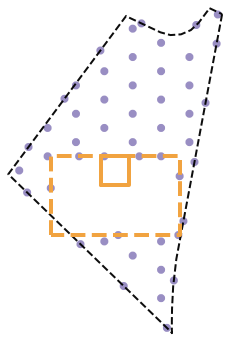

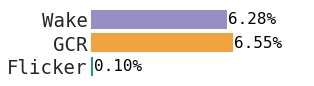

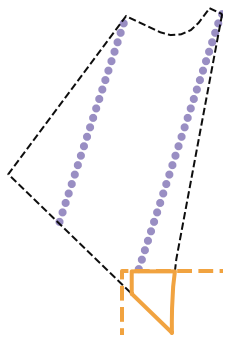

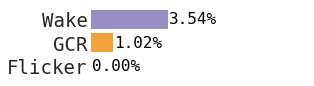

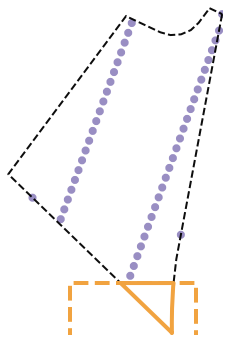

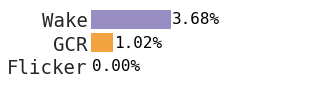

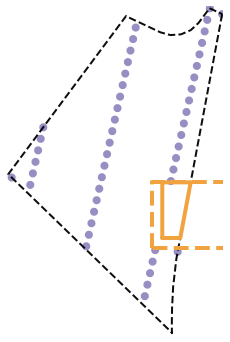

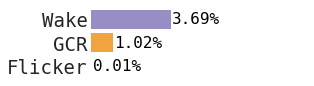

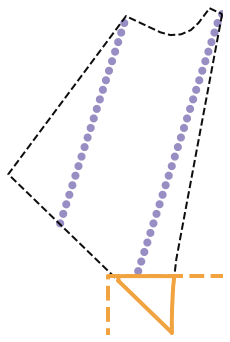

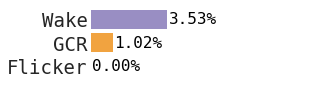

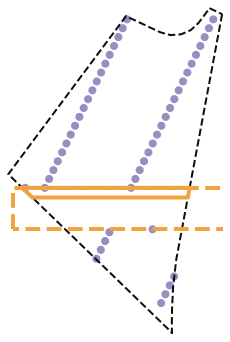

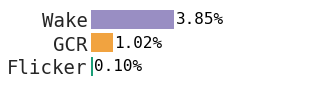

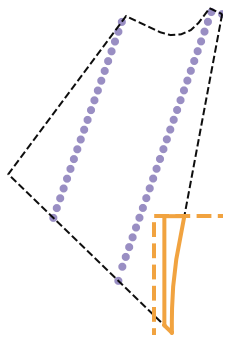

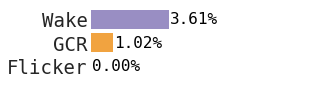

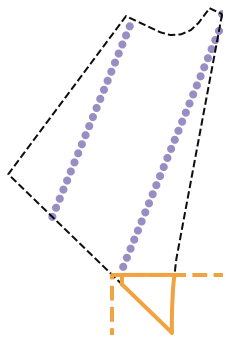

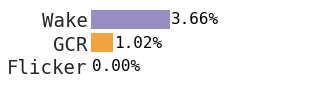

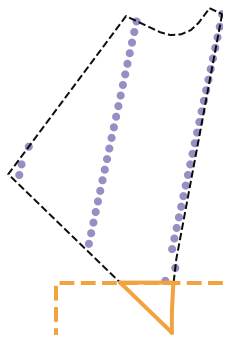

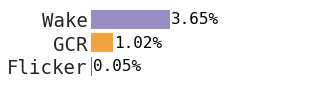

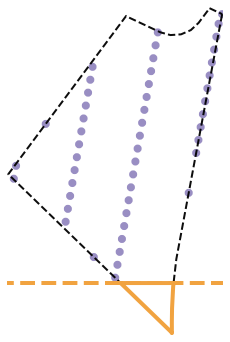

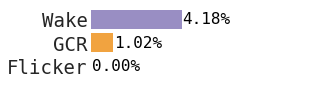

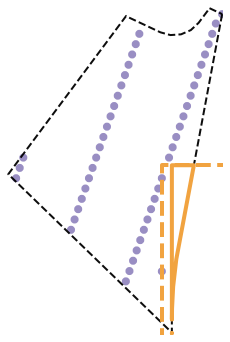

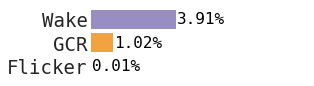

In [6]:
run_group = 'loc_1_site_irregular_method_CMAES_eval_50k'
runs = data_sets[run_group]
baseline_evaluation = plot_sites(site_data, config_file_name, runs, run_group, site_fig_size)

loc_1_site_irregular_method_CMAES_eval_50k mean 4.295902215459373 median 0.11530270106247224 stdev 4.329433478433131

loc_1_site_irregular_method_CEM_eval_50k mean 4.084914534114171 median 0.22337490032755383 stdev 3.964840298360599

loc_1_site_irregular_method_Stationary_eval_50k mean 3.8821585253945954 median 0.09507347673932087 stdev 3.8739002300718948



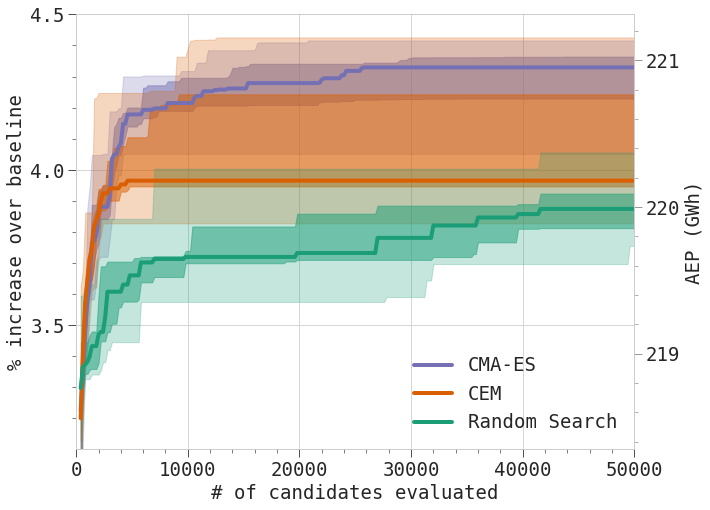

In [7]:

fig, ax, ax2 = plot_perf(aggregated_data_sets, baseline_evaluation, ordering)
plt.legend(['CMA-ES', 'CEM', 'Random Search'], loc='lower right')

ax.set_ylim(3.1, 4.5)
ax.set_yticks([3.5, 4.0, 4.5])
ax.set_xlim(0, 50000)
ax.set_xticks([0,10000,20000,30000,40000,50000])
ax2.set_yticks([219, 220, 221])
plt.savefig(name + 'progress.svg')

In [8]:
file_pattern = r'loc_1_.*site_circular.*'
name = 'loc_1_site_circular_'
baseline_value = 211781.79 # AEP of baseline irregular site, loc 1
ordering = ['loc_1_site_circular_method_CMAES_eval_50k',
        'loc_1_site_circular_method_CEM_eval_50k',
        'loc_1_site_circular_method_Stationary_eval_50k',]
config_file_name = directory + '/loc_1_site_circular_method_CMAES_eval_50k_2020-08-27T18.32.17.821695/config.json'
location = locations[1]
site_data = make_circular_site(lat=location[0], lon=location[1], elev=location[2])
data_sets, aggregated_data_sets, solution_vars = load_and_preprocess(directory, file_pattern)
site_fig_size = (5,5)

cols ['generation', 'mean', 'variance', 'covariance', 'iteration', 'num_evaluations', 'best_score', 'best_evaluation', 'best_solution']
cols ['generation', 'mean', 'variance', 'covariance', 'iteration', 'num_evaluations', 'best_score', 'best_evaluation', 'best_solution']
cols ['generation', 'mean', 'variance', 'covariance', 'iteration', 'num_evaluations', 'best_score', 'best_evaluation', 'best_solution']
cols ['generation', 'mean', 'variance', 'covariance', 'iteration', 'num_evaluations', 'best_score', 'best_evaluation', 'best_solution']
cols ['generation', 'mean', 'variance', 'covariance', 'iteration', 'num_evaluations', 'best_score', 'best_evaluation', 'best_solution']
cols ['generation', 'mean', 'variance', 'covariance', 'iteration', 'num_evaluations', 'best_score', 'best_evaluation', 'best_solution']
cols ['generation', 'mean', 'variance', 'covariance', '_sigma', '_p_c', '_p_sigma', 'iteration', 'num_evaluations', 'best_score', 'best_evaluation', 'best_solution']
cols ['generation'

['border_offset', 'border_spacing', 'grid_angle', 'grid_aspect_power', 'row_phase_offset', 'solar_aspect_power', 'solar_gcr', 'solar_s_buffer', 'solar_x_buffer', 'solar_x_position', 'solar_y_position']
site_center [0. 0.]
min_plot_bound [-3030. -3030.]
max_plot_bound [3030. 3030.]
dim [6060. 6060.]
make_conforming_candidate_and_get_penalty penalty 0.0
make_inner_candidate_from_parameters penalty 0.0
[596.1235865351066, 1693.6693351311887, 2523.167508113007, 2953.8470906256202, 2917.8898819672318, 2421.097917284922, 1541.9602441578418, 419.2687281564462, -769.7655143226569, -1837.4487275172262, -2615.1952559701967, -2980.1128035763154, -2874.3948433139703, -2313.882200637769, -1387.0313997107728, -2484.97230972133, -2484.97230972133, -2484.97230972133, -2484.97230972133, -1656.6482064808865, -1656.6482064808865, -1656.6482064808865, -1656.6482064808865, -1656.6482064808865, -1656.6482064808865, -828.3241032404433, -828.3241032404433, -828.3241032404433, -828.3241032404433, -828.32410324

make_inner_candidate_from_parameters penalty 0.029149587006301936
make_inner_candidate_from_parameters penalty 0.09345287021210522
[0.0, 970.9807676984173, -2322.229981275289, -2241.117667314371, -2160.005353353453, -2078.893039392535, 1195.483981891195, -1997.7807254316049, 1276.5962958521268, -1916.668411470685, 1357.7086098130458, -1835.5560975097678, 1438.820923773963, -1754.443783548838, 1519.9332377348928, -1673.3314695879335, 1601.0455516957973, -1592.2191556270018, 1682.157865656728, -1511.106841666071, 1763.2701796176598, -1429.9945277051656, 1844.3824935785651, -1348.8822137442357, 1925.494807539495, -1267.769899783304, 2006.6071215004267, -1186.6575858223987, 2087.719435461332, -1105.5452718614688, 2168.831749422262, -1024.4329579005635, 2249.9440633831673, -943.3206439396326, 2331.056377344097, -862.2083299787018, 2412.168691305029, -781.0960160177965, 2493.2810052659343, -699.9837020568657, 2574.393319226866, -618.8713880959613, 2655.5056331877686, -537.7590741350296, 2736

make_inner_candidate_from_parameters penalty 0.24963474053544607
make_inner_candidate_from_parameters penalty 0.0064321057849389745
[2506.524681506987, -2416.929210137258, -582.3668593250326, -2326.6852484792425, 774.4497869611532, -2251.866146003873, 849.2688894365238, -2177.0470435285033, 924.0879919118943, -2102.2279410531346, 998.9070943872612, -2027.408838577766, 1073.7261968626299, -1952.5897361023963, 1148.5452993379995, -1877.7706336270267, 1223.364401813369, -1802.951531151658, 1298.1835042887378, -1728.1324286762883, 1373.0026067641074, -1653.3133262009187, 1447.821709239477, -1578.49422372555, 1522.6408117148458, -1503.6751212501804, 1597.4599141902154, -1428.8560187748108, 1672.279016665585, -1354.036916299442, 1747.0981191409537, -1279.2178138240724, 1821.9172216163233, -1204.3987113487028, 1896.736324091693, -1129.579608873334, 1971.5554265670617, -1054.7605063979645, 2046.3745290424313, -979.9414039225949, 2121.193631517801, -905.1223014472262, 2196.0127339931696, -830.3

/Users/dguittet/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:120: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


make_inner_candidate_from_parameters penalty 0.037942980232120095
[5.922267260991649, 845.4761642674381, -2336.65001022032, -2254.6643238663864, -2172.678637512453, -2090.6929511585204, 1190.8571647232638, -2008.7072648045887, 1272.8428510771955, -1926.7215784506543, 1354.8285374311308, -1844.7358920967208, 1436.8142237850643, -1762.7502057427873, 1518.7999101389978, -1680.7645193888548, 1600.7855964929295, -1598.7788330349213, 1682.7712828468639, -1516.7931466809887, 1764.7569692007964, -1434.8074603270552, 1846.74265555473, -1352.8217739731226, 1928.7283419086625, -1270.8360876191891, 2010.714028262596, -1188.8504012652556, 2092.6997146165295, -1106.864714911323, 2174.685400970462, -1024.8790285573896, 2256.6710873243956, -942.893342203457, 2338.656773678328, -860.9076558495235, 2420.6424600322616, -778.9219694955909, 2502.628146386194, -696.9362831416574, 2584.6138327401277, -614.950596787724, 2666.599519094061, -532.9649104337923, 2748.585205447992, -450.9792240798588, 2830.5708918

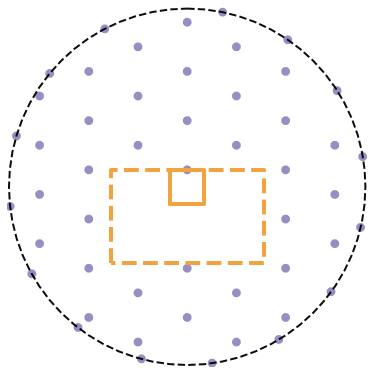

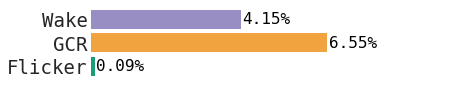

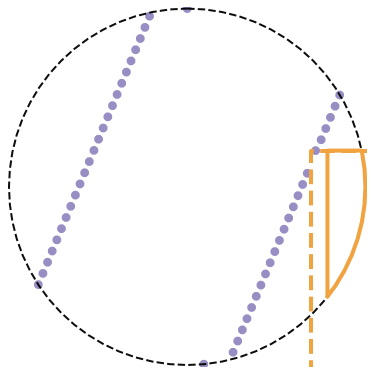

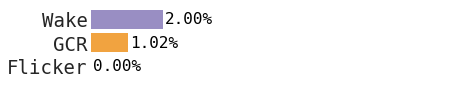

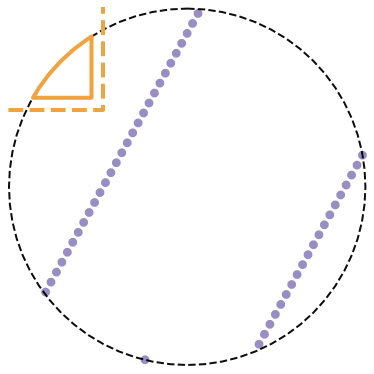

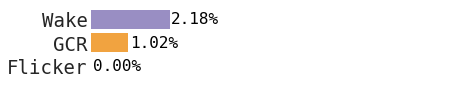

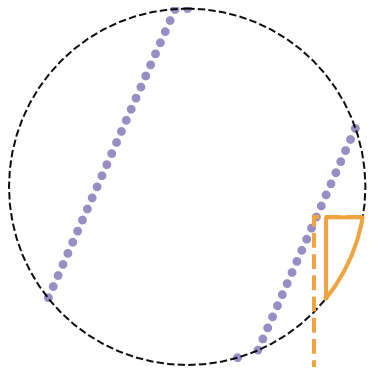

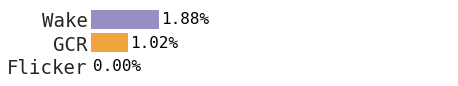

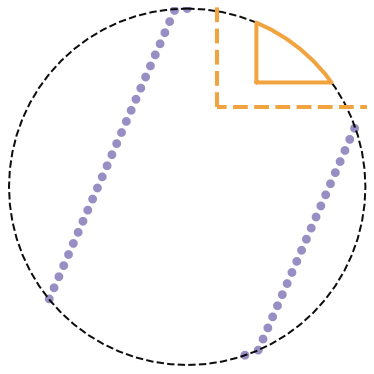

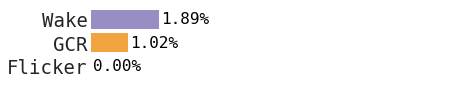

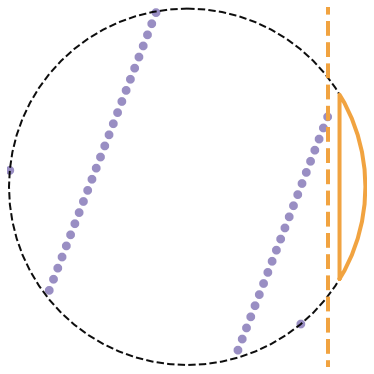

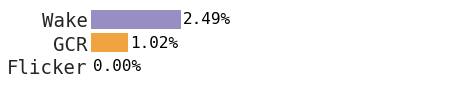

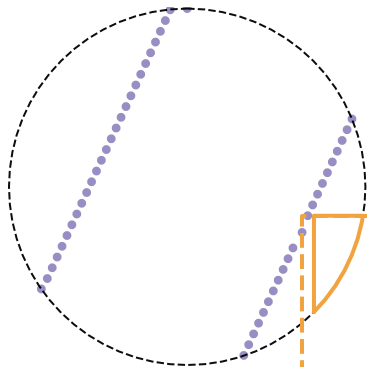

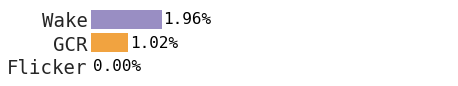

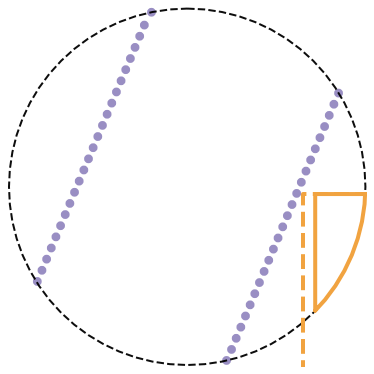

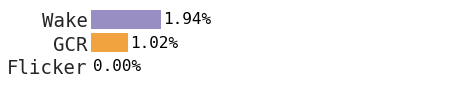

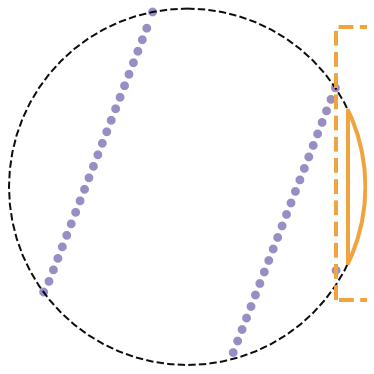

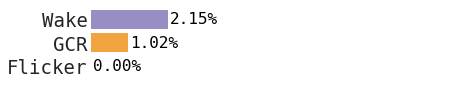

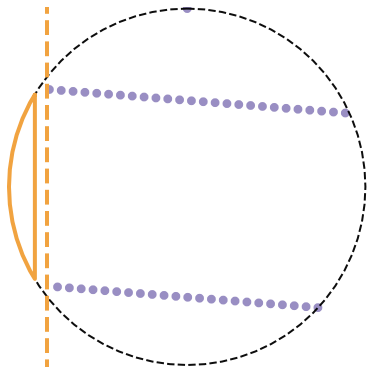

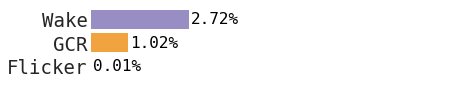

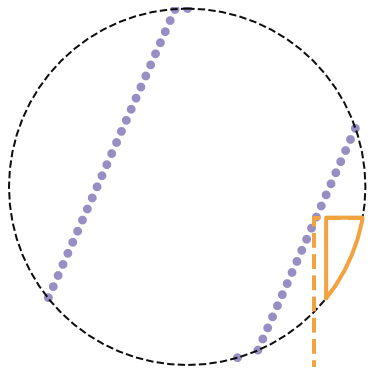

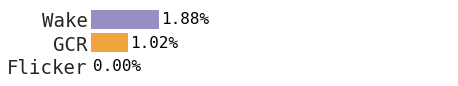

In [9]:
run_group = 'loc_1_site_circular_method_CMAES_eval_50k'
runs = data_sets[run_group]
baseline_evaluation = plot_sites(site_data, config_file_name, runs, run_group, site_fig_size)
print(baseline_evaluation)

loc_1_site_circular_method_CMAES_eval_50k mean 3.9725671183672047 median 0.15823424795693772 stdev 4.043644052964142

loc_1_site_circular_method_CEM_eval_50k mean 3.450559528165371 median 0.07863550936231921 stdev 3.4250469726809114

loc_1_site_circular_method_Stationary_eval_50k mean 3.453718609448452 median 0.07277548704303803 stdev 3.4685975244158644



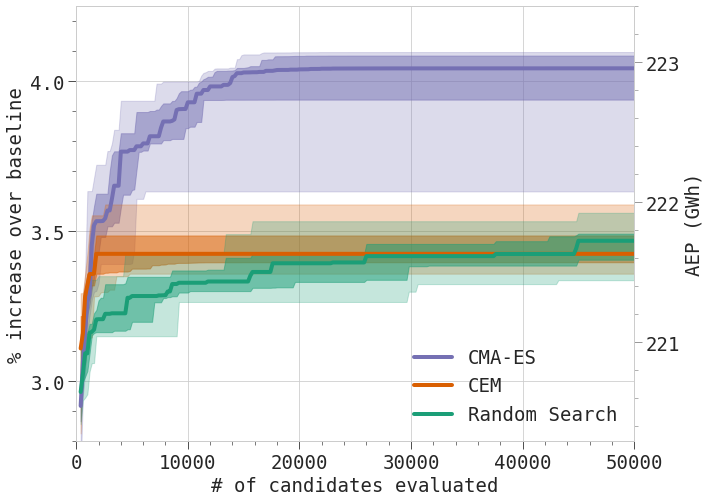

In [10]:


fig, ax, ax2 = plot_perf(aggregated_data_sets, baseline_evaluation, ordering)
plt.legend(['CMA-ES', 'CEM', 'Random Search'], loc='lower right')

ax.set_ylim(2.8, 4.25)
ax.set_yticks([3.0, 3.5, 4.0])
ax.set_xlim(0, 50000)
ax.set_xticks([0,10000,20000,30000,40000,50000])
ax2.set_yticks([221, 222, 223, 224])
plt.savefig(name + 'progress.svg')

In [11]:
file_pattern = r'loc_2_.*site_circular.*'
name = 'loc_2_site_circular_'
baseline_value = 211781.79 # AEP of baseline irregular site, loc 1
ordering = ['loc_2_site_circular_method_CMAES_eval_50k',
        'loc_2_site_circular_method_CEM_eval_50k',
        'loc_2_site_circular_method_Stationary_eval_50k',]
config_file_name = directory + '/loc_2_site_circular_method_CMAES_eval_50k_2020-08-27T19.18.59.364544/config.json'
location = locations[2]
site_data = make_circular_site(lat=location[0], lon=location[1], elev=location[2])
data_sets, aggregated_data_sets, solution_vars = load_and_preprocess(directory, file_pattern)
site_fig_size = (5,5)

cols ['generation', 'mean', 'variance', 'covariance', '_sigma', '_p_c', '_p_sigma', 'iteration', 'num_evaluations', 'best_score', 'best_evaluation', 'best_solution']
cols ['generation', 'mean', 'variance', 'covariance', 'iteration', 'num_evaluations', 'best_score', 'best_evaluation', 'best_solution']
cols ['generation', 'mean', 'variance', 'covariance', 'iteration', 'num_evaluations', 'best_score', 'best_evaluation', 'best_solution']
cols ['generation', 'mean', 'variance', 'covariance', 'iteration', 'num_evaluations', 'best_score', 'best_evaluation', 'best_solution']
cols ['generation', 'mean', 'variance', 'covariance', 'iteration', 'num_evaluations', 'best_score', 'best_evaluation', 'best_solution']
cols ['generation', 'mean', 'variance', 'covariance', '_sigma', '_p_c', '_p_sigma', 'iteration', 'num_evaluations', 'best_score', 'best_evaluation', 'best_solution']
cols ['generation', 'mean', 'variance', 'covariance', 'iteration', 'num_evaluations', 'best_score', 'best_evaluation', 'best

['border_offset', 'border_spacing', 'grid_angle', 'grid_aspect_power', 'row_phase_offset', 'solar_aspect_power', 'solar_gcr', 'solar_s_buffer', 'solar_x_buffer', 'solar_x_position', 'solar_y_position']
site_center [0. 0.]
min_plot_bound [-3030. -3030.]
max_plot_bound [3030. 3030.]
dim [6060. 6060.]
make_conforming_candidate_and_get_penalty penalty 0.0
make_inner_candidate_from_parameters penalty 0.0
[596.1235865351066, 1693.6693351311887, 2523.167508113007, 2953.8470906256202, 2917.8898819672318, 2421.097917284922, 1541.9602441578418, 419.2687281564462, -769.7655143226569, -1837.4487275172262, -2615.1952559701967, -2980.1128035763154, -2874.3948433139703, -2313.882200637769, -1387.0313997107728, -2484.97230972133, -2484.97230972133, -2484.97230972133, -2484.97230972133, -1656.6482064808865, -1656.6482064808865, -1656.6482064808865, -1656.6482064808865, -1656.6482064808865, -1656.6482064808865, -828.3241032404433, -828.3241032404433, -828.3241032404433, -828.3241032404433, -828.32410324

make_inner_candidate_from_parameters penalty 0.0
make_inner_candidate_from_parameters penalty 4.930380657631324e-32
[0.0, 969.7244186370506, 1835.3983735159654, 2505.0097756373743, 2901.34637526236, 2988.6831386435842, 2754.0059923776475, 2220.816320908013, 1451.1994459912355, 524.07969819303, -459.11490029231095, -1393.825426740365, -2176.711258423656, -2725.9260390464565, -2985.274304863698, -2917.304253479523, -2538.773801107318, -1888.149540197874, -1031.5609253606297, -2587.2821822469546, -2452.1679270334207, -2038.7275002403148, -1903.613245026781, -1768.4989898132471, -1633.384734599713, -1490.1728182336744, -1355.0585630201408, -1219.9443078066067, -1084.8300525930729, -806.5038810135011, -671.3896257999673, -536.2753705864334, -401.16111537289953, -257.94919900686125, -122.83494379332751, 147.3935666337402, 282.50782184727404, 290.6054829997788, 425.71973821331255, 560.8339934268463, 831.0625038539141, 974.2744202199523, 1109.3886754334862, 1244.50293064702, 1379.617185860554,

make_inner_candidate_from_parameters penalty 0.0
make_inner_candidate_from_parameters penalty 0.0
[136.95101101869773, 1084.9748384378038, 1920.4490910877084, 2552.8135897051006, 2920.3655351484217, 2985.564195019463, 2733.118339240259, 2197.887081343296, 1434.5312996623074, 519.4083315557392, -449.2350745651296, -1371.4983915222053, -2150.245959007605, -2702.787116099917, -2975.1749092007717, -2937.6028132643187, -2589.28459728001, -1973.012969438262, -1151.6206725431753, -2580.955046136824, -2453.243367172004, -2019.6217850816129, -1891.910106116793, -1764.198427151973, -1458.2885240264013, -1330.5768450615815, -1202.8651660967612, -1075.1534871319413, -896.9552629711901, -769.24358400637, -641.5319050415502, -513.8202260767301, -386.1085471119102, -207.91032295115883, -80.19864398633888, 175.2247139433009, 353.4229381040524, 481.13461706887244, 608.8462960336925, 736.5579749985123, 864.2696539633323, 1042.4678781240837, 1170.179557088904, 1297.8912360537238, 1425.6029150185436, 1731

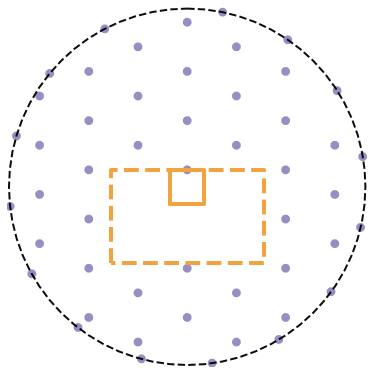

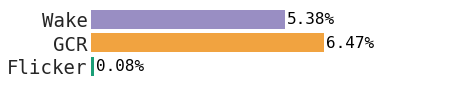

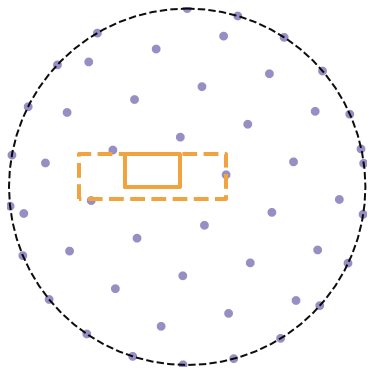

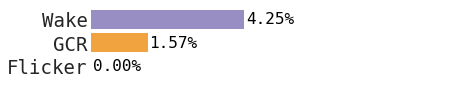

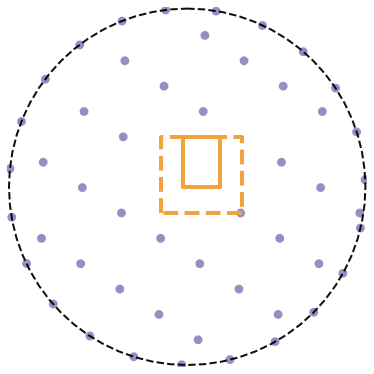

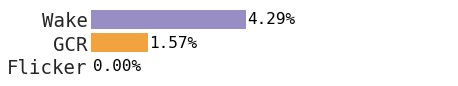

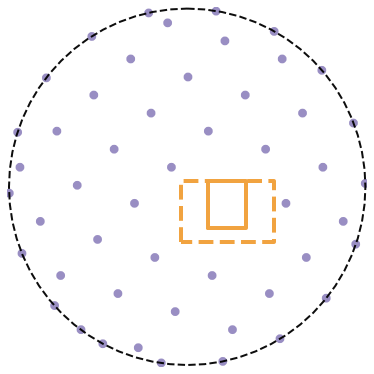

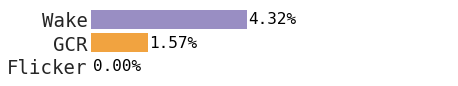

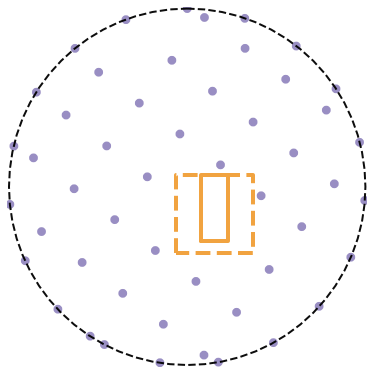

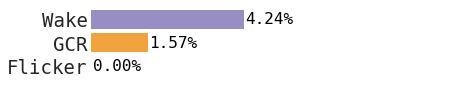

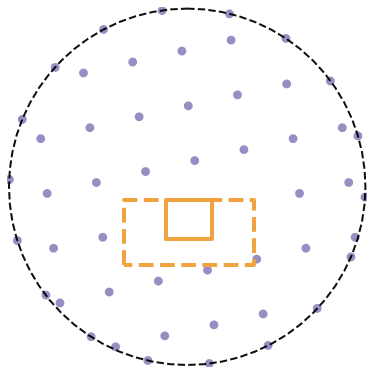

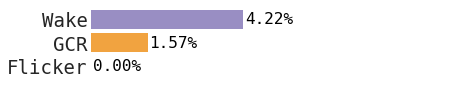

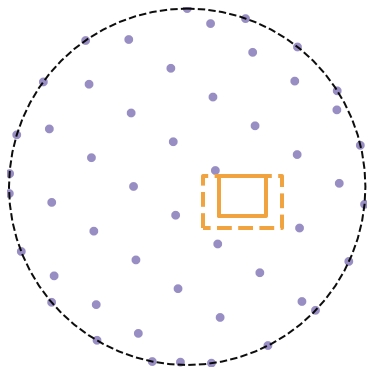

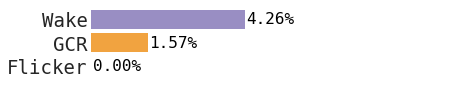

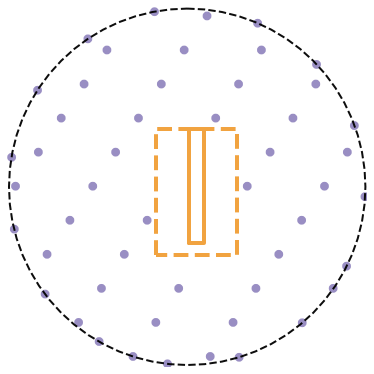

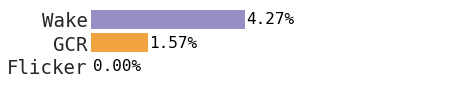

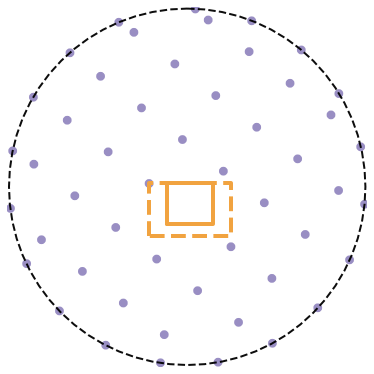

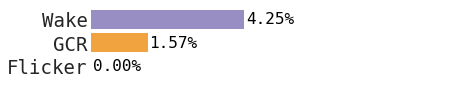

In [12]:
run_group = 'loc_2_site_circular_method_CMAES_eval_50k'
runs = data_sets[run_group]
baseline_evaluation = plot_sites(site_data, config_file_name, runs, run_group, site_fig_size)
print(baseline_evaluation)

loc_2_site_circular_method_CMAES_eval_50k mean 3.8815422104569373 median 0.011537028689444638 stdev 3.8836782792572397

loc_2_site_circular_method_CEM_eval_50k mean 3.8637669301030244 median 0.006811026534065784 stdev 3.865098026318776

loc_2_site_circular_method_Stationary_eval_50k mean 3.8029723033756198 median 0.010617030820920526 stdev 3.80264384304909



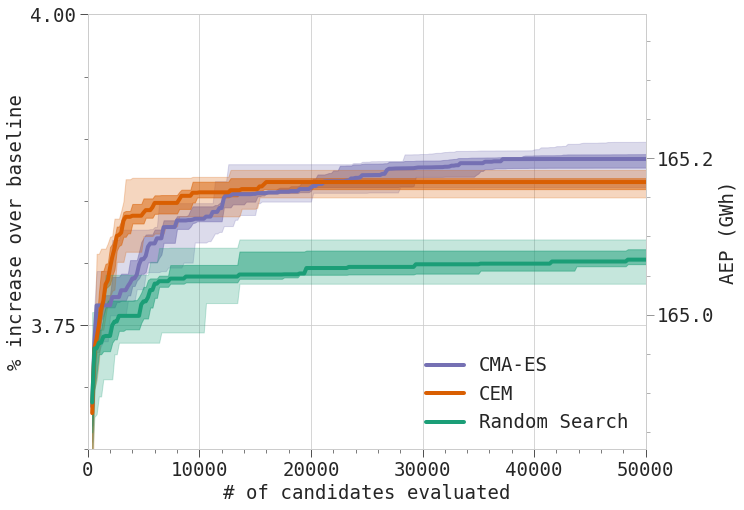

In [13]:
fig, ax, ax2 = plot_perf(aggregated_data_sets, baseline_evaluation, ordering)
plt.legend(['CMA-ES', 'CEM', 'Random Search'], loc='lower right')

ax.set_ylim(3.65, 4.0)
ax.set_yticks([3.75, 4.0])
ax.set_xlim(0, 50000)
ax.set_xticks([0,10000,20000,30000,40000,50000])
ax2.set_yticks([165.0, 165.2, 165.4])
plt.savefig(name + 'progress.svg')

In [14]:
file_pattern = r'loc_2_.*site_irregular.*'
name = 'loc_2_site_irregular_'
baseline_value = 211781.79 # AEP of baseline irregular site, loc 1
ordering = ['loc_2_site_irregular_method_CMAES_eval_50k',
        'loc_2_site_irregular_method_CEM_eval_50k',
        'loc_2_site_irregular_method_Stationary_eval_50k',]
config_file_name = directory + '/site_circular_method_CMAES_eval_20k_2020-08-25T20.29.20.768169/config.json'
location = locations[2]
site_data = make_irregular_site(lat=location[0], lon=location[1], elev=location[2])
data_sets, aggregated_data_sets, solution_vars = load_and_preprocess(directory, file_pattern)
site_fig_size = (3,5)

cols ['generation', 'mean', 'variance', 'covariance', '_sigma', '_p_c', '_p_sigma', 'iteration', 'num_evaluations', 'best_score', 'best_evaluation', 'best_solution']
cols ['generation', 'mean', 'variance', 'covariance', '_sigma', '_p_c', '_p_sigma', 'iteration', 'num_evaluations', 'best_score', 'best_evaluation', 'best_solution']
cols ['generation', 'mean', 'variance', 'covariance', 'iteration', 'num_evaluations', 'best_score', 'best_evaluation', 'best_solution']
cols ['generation', 'mean', 'variance', 'covariance', 'iteration', 'num_evaluations', 'best_score', 'best_evaluation', 'best_solution']
cols ['generation', 'mean', 'variance', 'covariance', 'iteration', 'num_evaluations', 'best_score', 'best_evaluation', 'best_solution']
cols ['generation', 'mean', 'variance', 'covariance', '_sigma', '_p_c', '_p_sigma', 'iteration', 'num_evaluations', 'best_score', 'best_evaluation', 'best_solution']
cols ['generation', 'mean', 'variance', 'covariance', 'iteration', 'num_evaluations', 'best_sc

['border_offset', 'border_spacing', 'grid_angle', 'grid_aspect_power', 'row_phase_offset', 'solar_aspect_power', 'solar_gcr', 'solar_s_buffer', 'solar_x_buffer', 'solar_x_position', 'solar_y_position']
site_center [-1026.17105263  -760.52105263]
min_plot_bound [-3180.24855263 -4035.04205263]
max_plot_bound [1127.90644737 2513.99994737]
dim [4308.155 6549.042]
make_conforming_candidate_and_get_penalty penalty 0.0
make_inner_candidate_from_parameters penalty 0.0
[996.2877630492268, 775.7053944108368, 555.1230257724469, 334.540657134057, 143.7105381183737, 5.325651757876628, -856.6524403037677, -1718.6245915253753, -966.4537644268668, 233.54623557313334, 259.03083803919856, -545.0807781531834, -1745.0807781531835, -2311.372943302354, -2782.6522905149764, -2755.0171201063154, -2038.2101523836418, -1321.4031846609685, -503.3956294853609, 591.2215986907049, -2940.093793782271, -2374.3045313958396, -2374.3045313958396, -1808.5152690094078, -1808.5152690094078, -1808.5152690094078, -1242.72600

make_inner_candidate_from_parameters penalty 0.028096470406678547
make_inner_candidate_from_parameters penalty 0.025642695090098845
[934.1847430402723, 860.6460467013881, 787.1073503625038, 713.5686540236195, 640.0299576847353, 566.4912613458511, 492.95256500696684, 419.4138686680825, 345.8751723291982, 272.33647599031406, 198.79777965142978, 150.72935067537813, 118.79200849793284, 104.88147648939507, 49.354426077711715, -238.01552807672908, -525.3854822311699, -812.7554363856107, -1100.1253905400515, -1387.493689650866, -1674.8599244509046, -1962.226159250944, -2249.5923940509824, -2536.958628851021, -2824.32486365106, -3111.6910984510987, -2959.2250410780257, -2720.25285912921, -2481.280677180394, -2242.3084952315785, -2003.3363132827624, -1764.3641313339465, -1525.3919493851306, -1286.419767436315, -1047.447585487499, -808.4754035386832, -450.2241679023034, -141.9956416696641, -141.9956416696641, 150.30711161541512, -2452.4393045544393, -2085.316577626002, -1718.193850697564, -1180.

make_inner_candidate_from_parameters penalty 0.028030741992828255
make_inner_candidate_from_parameters penalty 0.03475282754269471
[935.2125927623636, 861.6489136415711, 788.0852345207786, 714.5215553999863, 640.9578762791938, 567.3941971584013, 493.8305180376089, 420.2668389168165, 346.703159796024, 273.13948067523165, 199.5758015544393, 151.19705586999044, 118.99295565512702, 104.94346131486292, 52.004227131223004, -235.46335318806734, -522.9309335073576, -810.3985138266479, -1097.8660941459382, -1385.332047399536, -1672.795907100874, -1960.2597668022127, -2247.723626503551, -2535.187486204889, -2822.651345906227, -3110.1152056075653, -2960.4543605765607, -2721.400994296216, -2482.347628015872, -2243.2942617355275, -2004.2408954551834, -1765.1875291748393, -1526.134162894495, -1287.0807966141508, -1048.0274303338065, -808.9740640534624, -450.8567106254067, -385.38313982110463, -333.51889615610213, 66.67816170424834, 466.8752195645988, -945.167781415611, -2254.0315210331964, -698.8400

/Users/dguittet/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:120: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


make_inner_candidate_from_parameters penalty 0.0287904235664214
[939.7967043688741, 866.0909158228754, 792.3851272768768, 718.6793387308782, 644.9735501848795, 571.267761638881, 497.5619730928823, 423.8561845468837, 350.15039600088505, 276.4446074548864, 202.73881890888788, 153.07331208478803, 119.78751830691563, 105.18473506659676, 62.143164496605124, -225.87974221599325, -513.9026489285916, -801.9255556411898, -1089.9484623537883, -1377.9698372890934, -1665.9890161962949, -1954.0081951034963, -2242.027374010697, -2530.046552917898, -2818.0657318250987, -3106.0849107322992, -2963.344131250259, -2723.8289645694767, -2484.3137978886944, -2244.798631207912, -2005.2834645271294, -1765.7682978463467, -1526.2531311655644, -1286.737964484782, -1047.2227978039996, -807.7076311232172, -448.2381626434916, -238.60523297673217, -238.60523297673217, 149.97651737423212, -1318.4809212840946, -843.0208838181607, -2616.2791368089056, -367.56084635225125, -2140.819099342997, 107.89919111368363, -1665.3

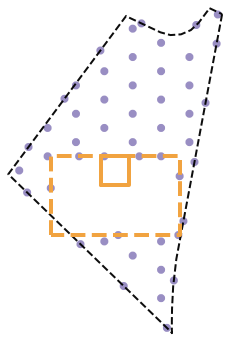

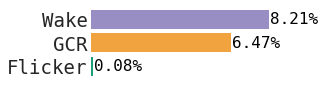

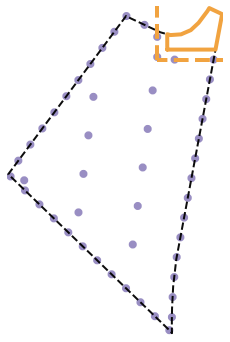

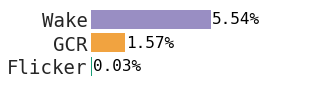

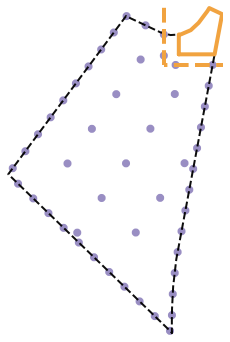

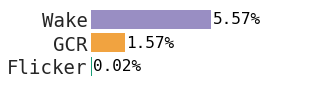

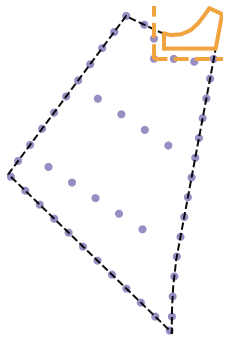

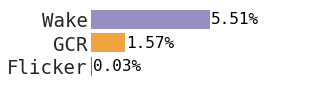

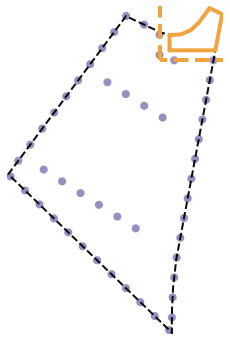

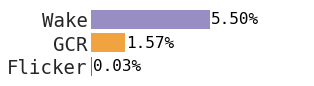

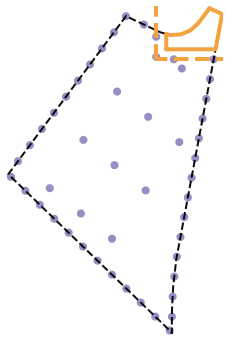

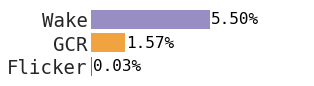

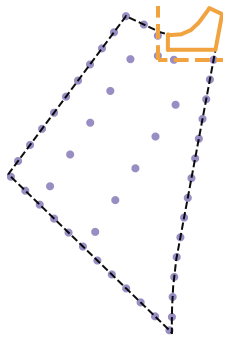

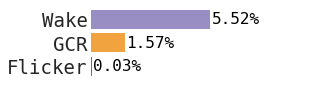

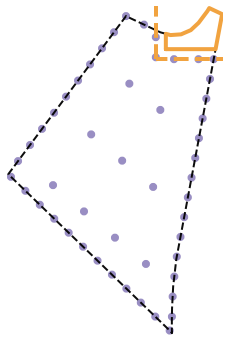

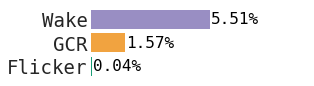

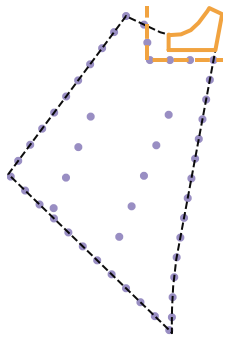

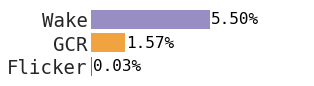

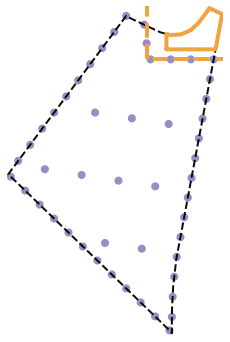

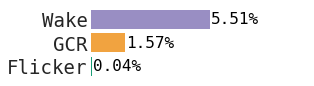

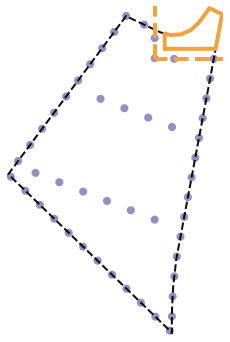

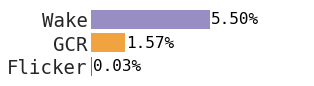

In [16]:
run_group = 'loc_2_site_irregular_method_CMAES_eval_50k'
runs = data_sets[run_group]
baseline_evaluation = plot_sites(site_data, config_file_name, runs, run_group, site_fig_size)

loc_2_site_irregular_method_CMAES_eval_50k mean 4.488161475346734 median 0.007022064696856838 stdev 4.490179161408648

loc_2_site_irregular_method_CEM_eval_50k mean 4.484363278098092 median 0.02056886931199571 stdev 4.476204068795743

loc_2_site_irregular_method_Stationary_eval_50k mean 4.368285771709782 median 0.042224496166972166 stdev 4.384185214489916



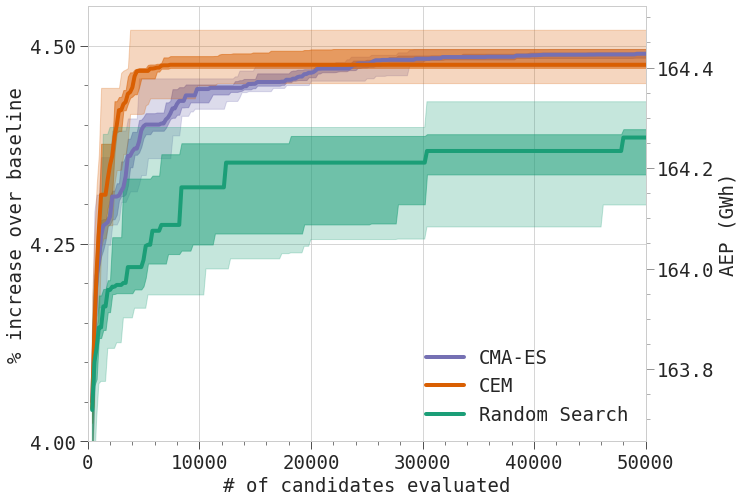

In [17]:
fig, ax, ax2 = plot_perf(aggregated_data_sets, baseline_evaluation, ordering)
plt.legend(['CMA-ES', 'CEM', 'Random Search'], loc='lower right')

ax.set_ylim(4.0, 4.55)
ax.set_yticks([4.0, 4.25, 4.5])
ax.set_xlim(0, 50000)
ax.set_xticks([0,10000,20000,30000,40000,50000])
ax2.set_yticks([163.8, 164, 164.2, 164.4])
plt.savefig(name + 'progress.svg')

In [18]:
font = {'family' : 'monospace',
        'weight' : 'medium',
        'size'   : 12}
plt.rc('font', **font)

In [19]:
file_pattern = r'loc_1_.*site_irregular.*'
name = 'loc_1_site_irregular_'
ordering = ['loc_1_site_irregular_method_CMAES_eval_50k',
        'loc_1_site_irregular_method_CEM_eval_50k',
        'loc_1_site_irregular_method_Stationary_eval_50k',]
config_file_name = directory + '/loc_1_site_irregular_method_CMAES_eval_50k_2020-08-27T18.22.30.269187/config.json'
location = locations[1]
site_data = make_irregular_site(lat=location[0], lon=location[1], elev=location[2])
data_sets, aggregated_data_sets, solution_vars = load_and_preprocess(directory, file_pattern)
site_fig_size = (3,5)

cols ['generation', 'mean', 'variance', 'covariance', '_sigma', '_p_c', '_p_sigma', 'iteration', 'num_evaluations', 'best_score', 'best_evaluation', 'best_solution']
cols ['generation', 'mean', 'variance', 'covariance', '_sigma', '_p_c', '_p_sigma', 'iteration', 'num_evaluations', 'best_score', 'best_evaluation', 'best_solution']
cols ['generation', 'mean', 'variance', 'covariance', 'iteration', 'num_evaluations', 'best_score', 'best_evaluation', 'best_solution']
cols ['generation', 'mean', 'variance', 'covariance', '_sigma', '_p_c', '_p_sigma', 'iteration', 'num_evaluations', 'best_score', 'best_evaluation', 'best_solution']
cols ['generation', 'mean', 'variance', 'covariance', '_sigma', '_p_c', '_p_sigma', 'iteration', 'num_evaluations', 'best_score', 'best_evaluation', 'best_solution']
cols ['generation', 'mean', 'variance', 'covariance', 'iteration', 'num_evaluations', 'best_score', 'best_evaluation', 'best_solution']
cols ['generation', 'mean', 'variance', 'covariance', 'iteration

In [21]:
config = {}
with open(config_file_name) as f:
  config = json.load(f)

site_info = SiteInfo(site_data)
inner_problem = HybridOptimizationProblem(site_info, config['num_turbines'], config['solar_capacity'])
problem = HybridParametrization(inner_problem)
optimizer = OptimizationDriver(problem, recorder=NullDataRecorder(), **config['optimizer_config'])

solution_name = 'best_solution'
solution_vars = None
run_group = 'loc_1_site_irregular_method_CMAES_eval_50k'
# group_data = aggregated_data_sets[run_group]
runs = data_sets[run_group]

# for run_group, runs in data_sets.items():
for run_name, data_set in runs.items():
    solutions = data_set[solution_name]
    candidates = [HybridCandidate(**json_candidate) for json_candidate in solutions]
    data_set[solution_name + '_candidate'] = solutions



    with multiprocessing.Pool() as pool:
        results = pool.map(
            lambda candidate: problem.get_losses(candidate, optimizer),
            candidates)

#         for result in results:
#             score, evaluation, wind_score, solar_score, wake_loss, gcr_loss, flicker_loss = result
#             scores.append(score)
#             evaluations.append(evaluation)
#             wind_scores.append(wind_score)
#             solar_scores.append(solar_score)
#             wake_losses.append(wake_loss)
#             gcr_losses.append(gcr_loss)
#             flicker_losses.append(flicker_loss)

#         for candidate in candidates:
#             score, evaluation, wind_score, solar_score, wake_loss, gcr_loss, flicker_loss = \
#                 problem.get_losses(candidate)
#             scores.append(score)
#             evaluations.append(evaluation)
#             wind_scores.append(wind_score)
#             solar_scores.append(solar_score)
#             wake_losses.append(wake_loss)
#             gcr_losses.append(gcr_loss)
#             flicker_losses.append(flicker_loss)

    data_set[solution_name + '_score'] = [result[0] for result in results]
    data_set[solution_name + '_evaluation'] = [result[1] for result in results]
    data_set[solution_name + '_wind_score'] = [result[2] for result in results]
    data_set[solution_name + '_solar_score'] = [result[3] for result in results]
    data_set[solution_name + '_wake_loss'] = [result[4] for result in results]
    data_set[solution_name + '_gcr_loss'] = [result[5] for result in results]
    data_set[solution_name + '_flicker_loss'] = [result[6] for result in results]
            
            
for run_name, data_set in runs.items():
    data_set.to_pickle('run_name.gzip')

['border_offset', 'border_spacing', 'grid_angle', 'grid_aspect_power', 'row_phase_offset', 'solar_aspect_power', 'solar_gcr', 'solar_s_buffer', 'solar_x_buffer', 'solar_x_position', 'solar_y_position']
make_conforming_candidate_and_get_penalty penaltymake_conforming_candidate_and_get_penalty penaltymake_conforming_candidate_and_get_penalty penalty make_conforming_candidate_and_get_penalty penalty  make_conforming_candidate_and_get_penalty penalty0.0make_conforming_candidate_and_get_penalty penalty make_conforming_candidate_and_get_penalty penalty0.00.0
 
make_conforming_candidate_and_get_penalty penalty 0.0 make_conforming_candidate_and_get_penalty penalty
make_conforming_candidate_and_get_penalty penalty0.0make_conforming_candidate_and_get_penalty penalty0.0 0.0
make_conforming_candidate_and_get_penalty penalty
   
0.0
0.0 0.00.0

0.0


make_inner_candidate_from_parameters penaltymake_inner_candidate_from_parameters penalty  52.6783661427595552.67836614275955make_inner_candidate_from_

make_inner_candidate_from_parameters penalty 79.89899564728408
make_conforming_candidate_and_get_penalty penalty 0.0
make_inner_candidate_from_parameters penalty 2.1565521011758317
make_inner_candidate_from_parameters penalty 53.895376388991444
make_inner_candidate_from_parameters penalty 53.895376388991444
make_inner_candidate_from_parameters penalty 53.895376388991444
make_conforming_candidate_and_get_penalty penalty 0.0
make_conforming_candidate_and_get_penalty penalty 0.0
make_conforming_candidate_and_get_penalty penalty 0.0
make_conforming_candidate_and_get_penalty penalty 0.0
make_conforming_candidate_and_get_penalty penalty 0.0
make_conforming_candidate_and_get_penalty penalty 0.0
make_conforming_candidate_and_get_penalty penalty 0.0
make_inner_candidate_from_parameters penalty 24.296569154946138
make_conforming_candidate_and_get_penalty penalty 0.0
make_conforming_candidate_and_get_penalty penalty 0.0
make_conforming_candidate_and_get_penalty penalty 0.0
make_inner_candidate_fr

make_conforming_candidate_and_get_penalty penalty 0.0
make_conforming_candidate_and_get_penalty penalty 0.0
make_inner_candidate_from_parameters penalty 24.2851998363086
make_inner_candidate_from_parameters penalty 24.2851998363086
make_conforming_candidate_and_get_penalty penalty 0.0
make_inner_candidate_from_parameters penalty 24.2851998363086
make_inner_candidate_from_parameters penalty 24.2851998363086
make_inner_candidate_from_parameters penalty 24.2851998363086
make_inner_candidate_from_parameters penalty 24.2851998363086
make_conforming_candidate_and_get_penalty penalty 0.0
make_inner_candidate_from_parameters penalty 82.33563296682311
make_inner_candidate_from_parameters penalty 24.2851998363086
make_conforming_candidate_and_get_penalty penalty 0.0
make_conforming_candidate_and_get_penalty penalty 0.0
make_conforming_candidate_and_get_penalty penalty 0.0
make_conforming_candidate_and_get_penalty penalty 0.0
make_conforming_candidate_and_get_penalty penalty 0.0
make_conforming_c

make_inner_candidate_from_parameters penalty 24.2851998363086
make_inner_candidate_from_parameters penalty 24.2851998363086
make_conforming_candidate_and_get_penalty penalty 0.0
make_conforming_candidate_and_get_penalty penalty 0.0
make_inner_candidate_from_parameters penalty 24.2851998363086
make_inner_candidate_from_parameters penalty 24.2851998363086
make_inner_candidate_from_parameters penalty 24.2851998363086
make_conforming_candidate_and_get_penalty penalty 0.0
make_inner_candidate_from_parameters penalty 24.2851998363086
make_inner_candidate_from_parameters penalty 24.2851998363086
make_conforming_candidate_and_get_penalty penalty 0.0
make_inner_candidate_from_parameters penalty 24.2851998363086
make_inner_candidate_from_parameters penalty 24.2851998363086
make_inner_candidate_from_parameters penalty 24.2851998363086
make_inner_candidate_from_parameters penalty 24.2851998363086
make_conforming_candidate_and_get_penalty penalty 0.0
make_conforming_candidate_and_get_penalty penalt

make_conforming_candidate_and_get_penalty penalty make_conforming_candidate_and_get_penalty penalty0.0 0.0

make_conforming_candidate_and_get_penalty penalty 0.0
make_conforming_candidate_and_get_penalty penalty 0.0
make_inner_candidate_from_parameters penalty 0.5050182581526518
make_inner_candidate_from_parameters penalty 1.3006646923837617
make_inner_candidate_from_parameters penalty 12.101866385319248
make_inner_candidate_from_parameters penalty 1.3006646923837617
make_inner_candidate_from_parameters penalty 2.5167764824649397
make_inner_candidate_from_parameters penalty 2.5167764824649397
make_inner_candidate_from_parameters penalty 2.5167764824649397
make_inner_candidate_from_parameters penalty 2.5167764824649397
make_inner_candidate_from_parameters penalty 2.5167764824649397
make_inner_candidate_from_parameters penalty 8.838661138606032
make_inner_candidate_from_parameters penalty 0.03470892248215014
make_inner_candidate_from_parameters penalty 10.105028511587806
make_conforming_

make_inner_candidate_from_parameters penalty 8.838661138606032
make_conforming_candidate_and_get_penalty penalty 0.0
make_inner_candidate_from_parameters penalty 8.838661138606032
make_conforming_candidate_and_get_penalty penalty 0.0
make_conforming_candidate_and_get_penalty penalty 0.0
make_conforming_candidate_and_get_penalty penalty 0.0
make_conforming_candidate_and_get_penalty penalty 0.0
make_conforming_candidate_and_get_penalty penalty 0.0
make_conforming_candidate_and_get_penalty penalty 0.0
make_inner_candidate_from_parameters penalty 8.838661138606032
make_conforming_candidate_and_get_penalty penalty 0.0
make_conforming_candidate_and_get_penalty penalty 0.0
make_conforming_candidate_and_get_penalty penalty 0.0
make_inner_candidate_from_parameters penalty 8.838661138606032
make_inner_candidate_from_parameters penalty 8.838661138606032
make_inner_candidate_from_parameters penalty 8.838661138606032
make_inner_candidate_from_parameters penalty 8.838661138606032make_inner_candidate

make_inner_candidate_from_parameters penalty 8.838661138606032
make_inner_candidate_from_parameters penalty 8.838661138606032
make_inner_candidate_from_parameters penalty 8.838661138606032
make_inner_candidate_from_parameters penalty 8.838661138606032
make_conforming_candidate_and_get_penalty penalty 0.0
make_inner_candidate_from_parameters penalty 8.838661138606032
make_inner_candidate_from_parameters penalty 8.838661138606032
make_inner_candidate_from_parameters penalty 8.838661138606032
make_conforming_candidate_and_get_penalty penalty 0.0
make_conforming_candidate_and_get_penalty penalty 0.0
make_conforming_candidate_and_get_penalty penalty 0.0
make_conforming_candidate_and_get_penalty penalty 0.0
make_conforming_candidate_and_get_penalty penalty 0.0
make_conforming_candidate_and_get_penalty penalty 0.0
make_conforming_candidate_and_get_penalty penalty 0.0
make_conforming_candidate_and_get_penalty penalty 0.0
make_conforming_candidate_and_get_penalty penalty 0.0
make_inner_candidat

make_inner_candidate_from_parameters penalty 8.838661138606032
make_conforming_candidate_and_get_penalty penalty 0.0
make_conforming_candidate_and_get_penalty penalty 0.0
make_conforming_candidate_and_get_penalty penalty 0.0
make_conforming_candidate_and_get_penalty penalty 0.0
make_inner_candidate_from_parameters penalty 8.838661138606032
make_inner_candidate_from_parameters penalty 8.838661138606032
make_conforming_candidate_and_get_penalty penalty 0.0
make_inner_candidate_from_parameters penalty 8.838661138606032
make_conforming_candidate_and_get_penalty penalty 0.0
make_inner_candidate_from_parameters penalty 8.838661138606032
make_inner_candidate_from_parameters penalty 8.838661138606032
make_inner_candidate_from_parameters penalty 8.838661138606032
make_conforming_candidate_and_get_penalty penalty 0.0
make_conforming_candidate_and_get_penalty penalty 0.0
make_inner_candidate_from_parameters penalty 8.838661138606032
make_inner_candidate_from_parameters penalty 8.838661138606032
m

make_inner_candidate_from_parameters penalty 34.11076785420486
make_conforming_candidate_and_get_penalty penalty 0.0
make_inner_candidate_from_parameters penalty 1.1203248045407026
make_inner_candidate_from_parameters penalty 1.1203248045407026
make_inner_candidate_from_parameters penalty 15.281529880089233
make_inner_candidate_from_parameters penalty 1.1203248045407026
make_conforming_candidate_and_get_penalty penalty 0.0
make_conforming_candidate_and_get_penalty penalty 0.0
make_conforming_candidate_and_get_penalty penalty 0.0
make_conforming_candidate_and_get_penalty penalty 0.0
make_conforming_candidate_and_get_penalty penalty 0.0
make_conforming_candidate_and_get_penalty penalty 0.0
make_conforming_candidate_and_get_penalty penalty 0.0
make_conforming_candidate_and_get_penalty penalty 0.0
make_inner_candidate_from_parameters penalty 1.3366925722972076
make_inner_candidate_from_parameters penalty 1.3366925722972076
make_inner_candidate_from_parameters penalty 1.3366925722972076
mak

make_conforming_candidate_and_get_penalty penalty 0.0
make_conforming_candidate_and_get_penalty penalty 0.0
make_conforming_candidate_and_get_penalty penalty 0.0
make_conforming_candidate_and_get_penalty penalty 0.0
make_inner_candidate_from_parameters penalty 0.0
make_inner_candidate_from_parameters penalty 1.6849956354712232
make_conforming_candidate_and_get_penalty penalty 0.0
make_inner_candidate_from_parameters penalty 2.202022489786637
make_conforming_candidate_and_get_penalty penalty 0.0
make_inner_candidate_from_parameters penalty 1.6849956354712232
make_conforming_candidate_and_get_penalty penalty 0.0
make_conforming_candidate_and_get_penalty penalty 0.0
make_inner_candidate_from_parameters penalty 2.3025334018121932
make_conforming_candidate_and_get_penalty penalty 0.0
make_conforming_candidate_and_get_penalty penalty 0.0
make_conforming_candidate_and_get_penalty penalty 0.0
make_inner_candidate_from_parameters penalty 1.3366925722972076
make_inner_candidate_from_parameters p

make_inner_candidate_from_parameters penalty 1.6069911514040502
make_conforming_candidate_and_get_penalty penalty 0.0
make_inner_candidate_from_parameters penalty 1.6069911514040502
make_inner_candidate_from_parameters penalty 1.6069911514040502
make_conforming_candidate_and_get_penalty penalty 0.0
make_conforming_candidate_and_get_penalty penalty 0.0
make_conforming_candidate_and_get_penalty penalty 0.0
make_conforming_candidate_and_get_penalty penalty 0.0
make_inner_candidate_from_parameters penalty 1.6069911514040502
make_inner_candidate_from_parameters penalty 1.6069911514040502
make_inner_candidate_from_parameters penalty 1.6069911514040502
make_conforming_candidate_and_get_penalty penalty 0.0
make_inner_candidate_from_parameters penalty 1.6069911514040502
make_conforming_candidate_and_get_penalty penalty 0.0
make_conforming_candidate_and_get_penalty penalty 0.0
make_inner_candidate_from_parameters penalty 1.6069911514040502
make_conforming_candidate_and_get_penalty penalty 0.0
ma

make_conforming_candidate_and_get_penalty penalty 0.0
make_conforming_candidate_and_get_penalty penalty 0.0
make_conforming_candidate_and_get_penalty penalty 0.0
make_conforming_candidate_and_get_penalty penalty 0.0
make_inner_candidate_from_parameters penalty 12.713302618926372
make_inner_candidate_from_parameters penalty 0.7892840150186717
make_inner_candidate_from_parameters penalty 0.7892840150186717
make_inner_candidate_from_parameters penalty 0.7892840150186717
make_inner_candidate_from_parameters penalty 0.7892840150186717
make_inner_candidate_from_parameters penalty 0.7892840150186717
make_inner_candidate_from_parameters penalty 0.7892840150186717
make_inner_candidate_from_parameters penalty 0.7892840150186717
make_inner_candidate_from_parameters penalty 1.480989163804151
make_inner_candidate_from_parameters penalty 6.395749136864839
make_inner_candidate_from_parameters penalty 0.7892840150186717
make_inner_candidate_from_parameters penalty 25.115625660317317
make_conforming_ca

make_conforming_candidate_and_get_penalty penalty 0.0
make_conforming_candidate_and_get_penalty penalty 0.0
make_conforming_candidate_and_get_penalty penalty 0.0
make_conforming_candidate_and_get_penalty penalty 0.0
make_conforming_candidate_and_get_penalty penalty 0.0
make_inner_candidate_from_parameters penalty 0.5257523040731507
make_inner_candidate_from_parameters penalty 2.382197760719395
make_conforming_candidate_and_get_penalty penalty 0.0
make_conforming_candidate_and_get_penalty penalty 0.0
make_inner_candidate_from_parameters penalty 0.6261633760250962
make_inner_candidate_from_parameters penalty 0.5257523040731507
make_inner_candidate_from_parameters penalty 0.6261633760250962
make_inner_candidate_from_parameters penalty 0.5257523040731507
make_inner_candidate_from_parameters penaltymake_inner_candidate_from_parameters penalty  0.52575230407315070.6261633760250962

make_inner_candidate_from_parameters penalty 0.6261633760250962
make_inner_candidate_from_parameters penalty 0.

make_inner_candidate_from_parameters penalty 0.5257523040731507
make_inner_candidate_from_parameters penalty 0.5257523040731507make_conforming_candidate_and_get_penalty penalty
 0.0
make_conforming_candidate_and_get_penalty penalty 0.0
make_inner_candidate_from_parameters penalty 0.5257523040731507
make_inner_candidate_from_parameters penalty 0.5257523040731507
make_conforming_candidate_and_get_penalty penalty 0.0
make_conforming_candidate_and_get_penalty penaltymake_conforming_candidate_and_get_penalty penalty  0.0
0.0
make_conforming_candidate_and_get_penalty penalty 0.0
make_conforming_candidate_and_get_penalty penalty 0.0
make_conforming_candidate_and_get_penalty penalty 0.0
make_conforming_candidate_and_get_penalty penalty 0.0
make_conforming_candidate_and_get_penalty penalty 0.0
make_conforming_candidate_and_get_penalty penalty 0.0
make_inner_candidate_from_parameters penalty 0.5257523040731507
make_inner_candidate_from_parameters penalty 0.5257523040731507
make_inner_candidate_f

make_conforming_candidate_and_get_penalty penalty 0.0
make_conforming_candidate_and_get_penalty penalty 0.0
make_conforming_candidate_and_get_penalty penalty 0.0
make_conforming_candidate_and_get_penalty penalty 0.0
make_conforming_candidate_and_get_penalty penalty 0.0
make_inner_candidate_from_parameters penalty 0.5257523040731507
make_inner_candidate_from_parameters penalty 0.5257523040731507
make_inner_candidate_from_parameters penalty 0.5257523040731507
make_inner_candidate_from_parameters penalty 0.5257523040731507
make_inner_candidate_from_parameters penalty 0.5257523040731507
make_conforming_candidate_and_get_penalty penalty 0.0
make_inner_candidate_from_parameters penalty 0.5257523040731507
make_conforming_candidate_and_get_penalty penalty 0.0
make_conforming_candidate_and_get_penalty penalty 0.0
make_conforming_candidate_and_get_penalty penalty 0.0
make_conforming_candidate_and_get_penalty penalty 0.0
make_conforming_candidate_and_get_penalty penalty 0.0
make_inner_candidate_f

make_conforming_candidate_and_get_penalty penalty 0.0
make_conforming_candidate_and_get_penalty penalty 0.0
make_conforming_candidate_and_get_penalty penalty 0.0
make_inner_candidate_from_parameters penalty 1.0547712323688598
make_inner_candidate_from_parameters penalty 2.755045878675852
make_conforming_candidate_and_get_penalty penalty 0.0
make_inner_candidate_from_parameters penalty 1.0547712323688598
make_inner_candidate_from_parameters penalty 1.0547712323688598
make_inner_candidate_from_parameters penalty 1.0547712323688598
make_inner_candidate_from_parameters penalty 1.0547712323688598
make_inner_candidate_from_parameters penalty 1.0547712323688598
make_inner_candidate_from_parameters penalty 1.0547712323688598
make_inner_candidate_from_parameters penalty 1.0547712323688598
make_inner_candidate_from_parameters penalty 1.0547712323688598
make_inner_candidate_from_parameters penalty 1.0547712323688598
make_inner_candidate_from_parameters penalty 0.0
make_conforming_candidate_and_ge

make_inner_candidate_from_parameters penalty 1.0547712323688598
make_inner_candidate_from_parameters penalty 1.0547712323688598
make_conforming_candidate_and_get_penalty penalty 0.0
make_conforming_candidate_and_get_penalty penalty 0.0
make_conforming_candidate_and_get_penalty penalty 0.0
make_conforming_candidate_and_get_penalty penalty 0.0
make_conforming_candidate_and_get_penalty penalty 0.0
make_conforming_candidate_and_get_penalty penalty 0.0
make_conforming_candidate_and_get_penalty penalty 0.0
make_conforming_candidate_and_get_penalty penalty 0.0
make_conforming_candidate_and_get_penalty penalty 0.0
make_conforming_candidate_and_get_penalty penalty 0.0
make_conforming_candidate_and_get_penalty penalty 0.0
make_conforming_candidate_and_get_penalty penalty 0.0
make_inner_candidate_from_parameters penalty 1.0547712323688598
make_inner_candidate_from_parameters penalty 1.0547712323688598
make_inner_candidate_from_parameters penalty 1.0547712323688598
make_inner_candidate_from_parame

make_inner_candidate_from_parameters penalty 1.0547712323688598
make_inner_candidate_from_parameters penalty 1.0547712323688598
make_inner_candidate_from_parameters penalty 1.0547712323688598
make_inner_candidate_from_parameters penalty 1.0547712323688598
make_inner_candidate_from_parameters penalty 1.0547712323688598
make_inner_candidate_from_parameters penalty 1.0547712323688598
make_inner_candidate_from_parameters penalty 1.0547712323688598
make_conforming_candidate_and_get_penalty penalty 0.0
make_conforming_candidate_and_get_penalty penalty 0.0
make_conforming_candidate_and_get_penalty penalty 0.0
make_conforming_candidate_and_get_penalty penalty 0.0
make_conforming_candidate_and_get_penalty penalty 0.0
make_conforming_candidate_and_get_penalty penalty 0.0
make_conforming_candidate_and_get_penalty penalty 0.0
make_conforming_candidate_and_get_penalty penalty 0.0
make_conforming_candidate_and_get_penalty penalty 0.0
make_conforming_candidate_and_get_penalty penalty 0.0
make_conform

make_conforming_candidate_and_get_penalty penaltymake_conforming_candidate_and_get_penalty penaltymake_conforming_candidate_and_get_penalty penaltymake_conforming_candidate_and_get_penalty penalty make_conforming_candidate_and_get_penalty penalty  make_conforming_candidate_and_get_penalty penalty 0.00.0 make_conforming_candidate_and_get_penalty penalty0.0 0.0make_conforming_candidate_and_get_penalty penalty

0.0 
0.0make_conforming_candidate_and_get_penalty penalty
 make_conforming_candidate_and_get_penalty penalty
0.0 
0.0 make_conforming_candidate_and_get_penalty penaltymake_conforming_candidate_and_get_penalty penalty

0.00.0  0.0

0.0

make_inner_candidate_from_parameters penalty make_inner_candidate_from_parameters penalty2.1010786296092503 
2.1010786296092503
make_inner_candidate_from_parameters penalty 2.1010786296092503
make_inner_candidate_from_parameters penalty 2.1010786296092503make_inner_candidate_from_parameters penalty 
make_inner_candidate_from_parameters penalty2.10107

make_conforming_candidate_and_get_penalty penalty 0.0
make_conforming_candidate_and_get_penalty penalty 0.0
make_inner_candidate_from_parameters penalty 0.44758003805693913
make_conforming_candidate_and_get_penalty penalty 0.0
make_conforming_candidate_and_get_penalty penalty 0.0
make_conforming_candidate_and_get_penalty penalty 0.0
make_conforming_candidate_and_get_penalty penalty 0.0make_conforming_candidate_and_get_penalty penalty
 0.0
make_conforming_candidate_and_get_penalty penalty 0.0
make_inner_candidate_from_parameters penalty 2.1010786296092503
make_inner_candidate_from_parameters penalty 1.952328627563816
make_inner_candidate_from_parameters penalty 1.952328627563816
make_inner_candidate_from_parameters penalty 1.952328627563816
make_inner_candidate_from_parameters penalty 3.4574311873746217
make_inner_candidate_from_parameters penalty 1.952328627563816
make_inner_candidate_from_parameters penalty 1.952328627563816
make_conforming_candidate_and_get_penalty penalty 0.0
make_i

make_conforming_candidate_and_get_penalty penaltymake_inner_candidate_from_parameters penalty  2.7932129266196055
0.0
make_inner_candidate_from_parameters penalty 0.9783351162459653
make_inner_candidate_from_parameters penalty 2.7932129266196055
make_conforming_candidate_and_get_penalty penalty 0.0
make_conforming_candidate_and_get_penalty penalty 0.0
make_conforming_candidate_and_get_penalty penalty 0.0
make_conforming_candidate_and_get_penalty penalty make_conforming_candidate_and_get_penalty penalty0.0 
0.0
make_conforming_candidate_and_get_penalty penalty 0.0
make_conforming_candidate_and_get_penalty penalty 0.0
make_conforming_candidate_and_get_penalty penalty 0.0
make_conforming_candidate_and_get_penalty penalty 0.0
make_inner_candidate_from_parameters penalty 1.6899709218504797
make_conforming_candidate_and_get_penalty penalty 0.0
make_inner_candidate_from_parameters penalty 1.3338224358925173
make_inner_candidate_from_parameters penalty 1.3338224358925173
make_inner_candidate_f

make_inner_candidate_from_parameters penalty make_inner_candidate_from_parameters penalty1.2392987487047218
 1.2126317336090136
make_inner_candidate_from_parameters penalty 1.3338224358925173
make_inner_candidate_from_parameters penalty 1.2392987487047218
make_inner_candidate_from_parameters penalty 1.2430968061682544
make_inner_candidate_from_parameters penalty 1.2126317336090136
make_inner_candidate_from_parameters penalty 1.2430968061682544
make_inner_candidate_from_parameters penalty 1.2430968061682544
make_inner_candidate_from_parameters penalty 1.2430968061682544
make_conforming_candidate_and_get_penalty penalty 0.0
make_conforming_candidate_and_get_penalty penalty 0.0
make_conforming_candidate_and_get_penalty penalty 0.0
make_conforming_candidate_and_get_penalty penalty 0.0
make_conforming_candidate_and_get_penalty penalty 0.0
make_conforming_candidate_and_get_penalty penalty 0.0
make_conforming_candidate_and_get_penalty penalty 0.0
make_conforming_candidate_and_get_penalty pena

make_conforming_candidate_and_get_penalty penalty 0.0
make_conforming_candidate_and_get_penalty penalty 0.0
make_conforming_candidate_and_get_penalty penalty 0.0
make_inner_candidate_from_parameters penalty 0.5634609501514035
make_inner_candidate_from_parameters penalty 0.5634609501514035
make_inner_candidate_from_parameters penaltymake_inner_candidate_from_parameters penalty  0.64440562456139870.5634609501514035

make_inner_candidate_from_parameters penalty 0.6444056245613987
make_inner_candidate_from_parameters penalty 0.6444056245613987
make_inner_candidate_from_parameters penalty 0.6444056245613987
make_conforming_candidate_and_get_penalty penalty 0.0
make_conforming_candidate_and_get_penalty penalty 0.0
make_inner_candidate_from_parameters penalty 34.77687402292168
make_inner_candidate_from_parameters penalty 22.459597234383374
make_inner_candidate_from_parameters penalty 0.6137988146509342
make_inner_candidate_from_parameters penalty 19.41978334171164
make_inner_candidate_from_pa

make_conforming_candidate_and_get_penalty penalty 0.0
make_conforming_candidate_and_get_penalty penalty 0.0
make_conforming_candidate_and_get_penalty penalty 0.0
make_conforming_candidate_and_get_penalty penalty 0.0
make_inner_candidate_from_parameters penalty 0.5634609501514035
make_inner_candidate_from_parameters penalty 0.5634609501514035
make_inner_candidate_from_parameters penalty 0.5634609501514035
make_inner_candidate_from_parameters penalty 0.5634609501514035
make_inner_candidate_from_parameters penalty 0.5634609501514035make_inner_candidate_from_parameters penalty
 0.5634609501514035
make_inner_candidate_from_parameters penalty 0.5634609501514035make_inner_candidate_from_parameters penalty
 0.5634609501514035
make_inner_candidate_from_parameters penalty 0.5634609501514035
make_conforming_candidate_and_get_penalty penalty 0.0
make_conforming_candidate_and_get_penalty penalty 0.0
make_inner_candidate_from_parameters penalty 0.5634609501514035
make_conforming_candidate_and_get_pe

make_conforming_candidate_and_get_penalty penalty 0.0
make_inner_candidate_from_parameters penalty 0.5634609501514035
make_conforming_candidate_and_get_penalty penalty 0.0
make_conforming_candidate_and_get_penalty penalty 0.0
make_conforming_candidate_and_get_penalty penaltymake_conforming_candidate_and_get_penalty penalty  0.0
0.0make_conforming_candidate_and_get_penalty penalty
 0.0
make_conforming_candidate_and_get_penalty penalty 0.0
make_inner_candidate_from_parameters penalty 0.5634609501514035
make_conforming_candidate_and_get_penalty penalty 0.0
make_conforming_candidate_and_get_penalty penalty 0.0
make_conforming_candidate_and_get_penalty penalty 0.0
make_inner_candidate_from_parameters penalty 0.5634609501514035
make_inner_candidate_from_parameters penalty 0.5634609501514035
make_inner_candidate_from_parameters penalty 0.5634609501514035
make_inner_candidate_from_parameters penalty 0.5634609501514035
make_inner_candidate_from_parameters penalty 0.5634609501514035
make_inner_c

make_conforming_candidate_and_get_penalty penalty 0.0
make_conforming_candidate_and_get_penalty penalty 0.0
make_conforming_candidate_and_get_penalty penalty 0.0
make_conforming_candidate_and_get_penalty penalty 0.0
make_conforming_candidate_and_get_penalty penalty 0.0
make_inner_candidate_from_parameters penalty 0.5634609501514035
make_inner_candidate_from_parameters penalty 0.5634609501514035
make_inner_candidate_from_parameters penalty 0.5634609501514035
make_inner_candidate_from_parameters penalty 0.5634609501514035
make_inner_candidate_from_parameters penalty 0.5634609501514035
make_inner_candidate_from_parameters penalty 0.5634609501514035
make_conforming_candidate_and_get_penalty penalty 0.0
make_conforming_candidate_and_get_penalty penalty 0.0
make_conforming_candidate_and_get_penalty penalty 0.0
make_conforming_candidate_and_get_penalty penalty 0.0
make_conforming_candidate_and_get_penalty penalty 0.0
make_inner_candidate_from_parameters penalty 0.5634609501514035
make_inner_c

make_conforming_candidate_and_get_penalty penalty make_conforming_candidate_and_get_penalty penalty0.0
 0.0
make_conforming_candidate_and_get_penalty penalty 0.0
make_inner_candidate_from_parameters penalty 3.6137699393889258
make_inner_candidate_from_parameters penalty 0.5511422255975996
make_inner_candidate_from_parameters penalty 2.4466726949331727
make_conforming_candidate_and_get_penalty penalty 0.0
make_conforming_candidate_and_get_penalty penalty 0.0
make_conforming_candidate_and_get_penalty penalty 0.0
make_inner_candidate_from_parameters penalty 0.9576757008710614
make_inner_candidate_from_parameters penalty 0.9576757008710614
make_inner_candidate_from_parameters penaltymake_inner_candidate_from_parameters penalty  0.95767570087106140.9576757008710614

make_inner_candidate_from_parameters penalty 0.9576757008710614
make_inner_candidate_from_parameters penalty 2.135389538719844
make_inner_candidate_from_parameters penalty 2.4466726949331727
make_conforming_candidate_and_get_pen

make_conforming_candidate_and_get_penalty penalty 0.0
make_conforming_candidate_and_get_penalty penalty 0.0
make_conforming_candidate_and_get_penalty penalty 0.0
make_conforming_candidate_and_get_penalty penalty 0.0
make_inner_candidate_from_parameters penalty 0.9576757008710614
make_inner_candidate_from_parameters penalty 0.9348652504904778
make_inner_candidate_from_parameters penalty 0.9348652504904778
make_conforming_candidate_and_get_penalty penalty 0.0
make_inner_candidate_from_parameters penalty 0.9348652504904778
make_inner_candidate_from_parameters penalty 0.9576757008710614
make_conforming_candidate_and_get_penalty penalty 0.0
make_conforming_candidate_and_get_penalty penalty 0.0
make_conforming_candidate_and_get_penalty penalty 0.0
make_inner_candidate_from_parameters penalty 0.9348652504904778
make_conforming_candidate_and_get_penalty penalty 0.0
make_conforming_candidate_and_get_penalty penalty 0.0
make_conforming_candidate_and_get_penalty penalty 0.0
make_inner_candidate_f

make_conforming_candidate_and_get_penalty penalty 0.0
make_conforming_candidate_and_get_penalty penalty 0.0
make_conforming_candidate_and_get_penalty penalty 0.0
make_inner_candidate_from_parameters penalty 0.9348652504904778
make_conforming_candidate_and_get_penalty penalty 0.0
make_inner_candidate_from_parameters penalty 0.9348652504904778
make_inner_candidate_from_parameters penalty 0.9348652504904778
make_inner_candidate_from_parameters penalty 0.9348652504904778
make_conforming_candidate_and_get_penalty penaltymake_conforming_candidate_and_get_penalty penalty  0.00.0

make_inner_candidate_from_parameters penalty 0.9348652504904778
make_inner_candidate_from_parameters penalty 0.9348652504904778
make_inner_candidate_from_parameters penalty 0.9348652504904778
make_inner_candidate_from_parameters penalty 0.9348652504904778
make_conforming_candidate_and_get_penalty penalty 0.0
make_inner_candidate_from_parameters penaltymake_inner_candidate_from_parameters penalty  0.93486525049047780.

 86.29230399964561
make_inner_candidate_from_parameters penalty 4.822658642550289
make_conforming_candidate_and_get_penalty penalty 0.0
make_conforming_candidate_and_get_penalty penalty 0.0
make_conforming_candidate_and_get_penalty penalty 0.0
make_conforming_candidate_and_get_penalty penalty 0.0make_conforming_candidate_and_get_penalty penalty 
0.0
make_conforming_candidate_and_get_penalty penalty 0.0
make_conforming_candidate_and_get_penalty penalty 0.0
make_conforming_candidate_and_get_penalty penalty 0.0
make_conforming_candidate_and_get_penalty penalty 0.0
make_conforming_candidate_and_get_penalty penalty 0.0
make_conforming_candidate_and_get_penalty penalty 0.0
make_conforming_candidate_and_get_penalty penalty 0.0
make_inner_candidate_from_parameters penalty 9.29566572769215
make_inner_candidate_from_parameters penalty 86.29230399964561
make_inner_candidate_from_parameters penalty 86.29230399964561
make_inner_candidate_from_parameters penalty 86.29230399964561
make_inner_candidat

make_inner_candidate_from_parameters penalty 86.29230399964561
make_inner_candidate_from_parameters penalty 86.29230399964561
make_inner_candidate_from_parameters penalty 86.29230399964561
make_inner_candidate_from_parameters penalty 86.29230399964561
make_conforming_candidate_and_get_penalty penalty 0.0
make_inner_candidate_from_parameters penalty 86.29230399964561
make_conforming_candidate_and_get_penalty penalty 0.0
make_conforming_candidate_and_get_penalty penalty make_conforming_candidate_and_get_penalty penalty0.0
 0.0make_conforming_candidate_and_get_penalty penalty 
0.0
make_conforming_candidate_and_get_penalty penalty 0.0
make_conforming_candidate_and_get_penalty penalty 0.0make_conforming_candidate_and_get_penalty penalty
 0.0
make_conforming_candidate_and_get_penalty penalty 0.0
make_conforming_candidate_and_get_penalty penalty 0.0
make_conforming_candidate_and_get_penalty penalty 0.0
make_conforming_candidate_and_get_penalty penalty 0.0
make_inner_candidate_from_parameters 

make_inner_candidate_from_parameters penalty 86.29230399964561
make_inner_candidate_from_parameters penalty 86.29230399964561
make_inner_candidate_from_parameters penalty 86.29230399964561
make_inner_candidate_from_parameters penalty 86.29230399964561
make_inner_candidate_from_parameters penalty 86.29230399964561
make_inner_candidate_from_parameters penalty 86.29230399964561
make_inner_candidate_from_parameters penaltymake_inner_candidate_from_parameters penalty  86.2923039996456186.29230399964561

make_inner_candidate_from_parameters penalty 86.29230399964561
make_inner_candidate_from_parameters penalty 86.29230399964561
make_conforming_candidate_and_get_penalty penalty 0.0
make_inner_candidate_from_parameters penalty 86.29230399964561
make_conforming_candidate_and_get_penalty penalty 0.0
make_conforming_candidate_and_get_penalty penalty 0.0
make_conforming_candidate_and_get_penalty penalty 0.0
make_conforming_candidate_and_get_penalty penalty 0.0
make_conforming_candidate_and_get_pen

make_inner_candidate_from_parameters penalty 86.29230399964561
make_inner_candidate_from_parameters penalty 86.29230399964561
make_inner_candidate_from_parameters penalty 86.29230399964561
make_conforming_candidate_and_get_penalty penalty 0.0
make_inner_candidate_from_parameters penalty 86.29230399964561
make_conforming_candidate_and_get_penalty penalty 0.0
make_conforming_candidate_and_get_penalty penalty 0.0
make_conforming_candidate_and_get_penalty penalty 0.0
make_conforming_candidate_and_get_penalty penalty 0.0
make_conforming_candidate_and_get_penalty penalty 0.0
make_inner_candidate_from_parameters penalty 86.29230399964561
make_inner_candidate_from_parameters penalty 86.29230399964561
make_inner_candidate_from_parameters penalty 86.29230399964561
make_inner_candidate_from_parameters penalty 86.29230399964561
make_inner_candidate_from_parameters penalty 86.29230399964561
make_conforming_candidate_and_get_penalty penalty 0.0
make_inner_candidate_from_parameters penalty 86.2923039

make_conforming_candidate_and_get_penalty penalty 0.0
make_conforming_candidate_and_get_penalty penalty 0.0
make_conforming_candidate_and_get_penalty penalty 0.0make_conforming_candidate_and_get_penalty penalty 
0.0
make_conforming_candidate_and_get_penalty penalty 0.0
make_conforming_candidate_and_get_penalty penalty 0.0
make_conforming_candidate_and_get_penalty penalty 0.0
make_conforming_candidate_and_get_penalty penalty 0.0
make_inner_candidate_from_parameters penalty 18.323059431501942
make_inner_candidate_from_parameters penalty 18.323059431501942
make_inner_candidate_from_parameters penalty 18.323059431501942
make_inner_candidate_from_parameters penalty 18.323059431501942
make_inner_candidate_from_parameters penalty 18.323059431501942
make_inner_candidate_from_parameters penalty 18.323059431501942
make_inner_candidate_from_parameters penalty 18.323059431501942
make_inner_candidate_from_parameters penalty 18.323059431501942
make_inner_candidate_from_parameters penalty 18.32305943

make_inner_candidate_from_parameters penalty 18.323059431501942
make_inner_candidate_from_parameters penalty 18.323059431501942
make_inner_candidate_from_parameters penalty 18.323059431501942
make_conforming_candidate_and_get_penalty penalty 0.0
make_conforming_candidate_and_get_penalty penalty 0.0
make_conforming_candidate_and_get_penalty penalty 0.0
make_conforming_candidate_and_get_penalty penalty 0.0
make_conforming_candidate_and_get_penalty penalty 0.0
make_conforming_candidate_and_get_penalty penalty 0.0
make_conforming_candidate_and_get_penalty penalty 0.0
make_conforming_candidate_and_get_penalty penalty 0.0
make_conforming_candidate_and_get_penalty penalty 0.0
make_conforming_candidate_and_get_penalty penalty 0.0
make_conforming_candidate_and_get_penalty penalty 0.0
make_conforming_candidate_and_get_penalty penalty 0.0
make_inner_candidate_from_parameters penalty 18.323059431501942
make_inner_candidate_from_parameters penalty 18.323059431501942
make_inner_candidate_from_parame

make_inner_candidate_from_parameters penalty 18.323059431501942
make_inner_candidate_from_parameters penalty 18.323059431501942
make_inner_candidate_from_parameters penalty 18.323059431501942
make_inner_candidate_from_parameters penalty 18.323059431501942
make_inner_candidate_from_parameters penalty 18.323059431501942
make_inner_candidate_from_parameters penalty 18.323059431501942
make_inner_candidate_from_parameters penalty 18.323059431501942
make_inner_candidate_from_parameters penalty 18.323059431501942
make_conforming_candidate_and_get_penalty penalty 0.0
make_conforming_candidate_and_get_penalty penalty 0.0
make_conforming_candidate_and_get_penalty penalty 0.0
make_conforming_candidate_and_get_penalty penalty 0.0
make_conforming_candidate_and_get_penalty penalty 0.0make_conforming_candidate_and_get_penalty penaltymake_conforming_candidate_and_get_penalty penalty
  0.00.0

make_conforming_candidate_and_get_penalty penalty 0.0
make_conforming_candidate_and_get_penalty penalty 0.0
ma

make_conforming_candidate_and_get_penalty penalty 0.0
make_conforming_candidate_and_get_penalty penalty 0.0
make_inner_candidate_from_parameters penalty 18.323059431501942
make_inner_candidate_from_parameters penalty 18.323059431501942


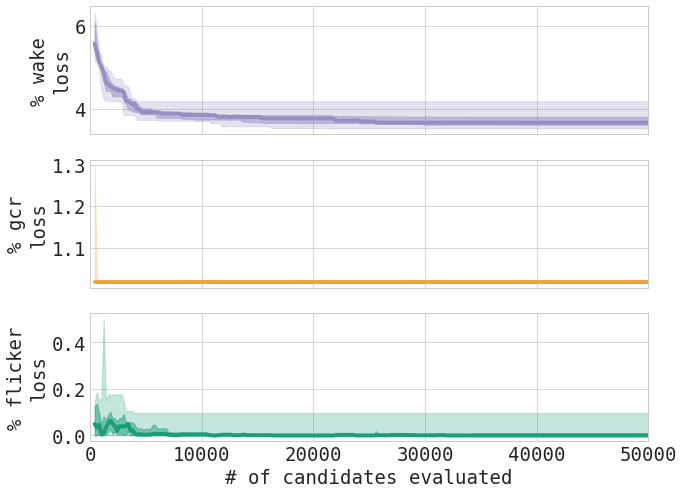

In [24]:
font = {'family' : 'monospace',
        'weight' : 'medium',
        'size'   : 19}
plt.rc('font', **font)

run_group = 'loc_1_site_irregular_method_CMAES_eval_50k'
aggregated_data_sets = make_aggregated_data_set(data_sets)
loss_vars = ['wake_loss', 'gcr_loss', 'flicker_loss']
loss_colors = [wind_color, solar_color, flicker_color]
fig, axs = plt.subplots(len(loss_vars), sharex=True, figsize=(10,8))
for i, var in enumerate(loss_vars):
    col_name = 'best_solution_' + var
    ax = axs[i]
    ax.set_xlim(0, 50000)
    ax.set(ylabel='% ' + var.replace('_','\n'))
    run_data = aggregated_data_sets[run_group]
    x = run_data['num_evaluations'].median(1) + 200
    plot_quantiles(ax, x, run_data[col_name], color=loss_colors[i])

plt.xlabel('# of candidates evaluated')
plt.savefig(name + 'loss_progress.svg')

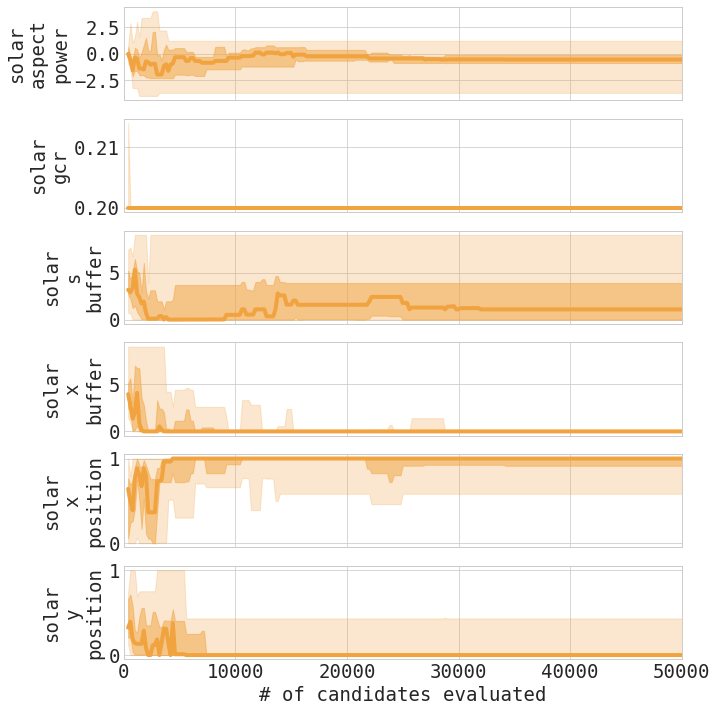

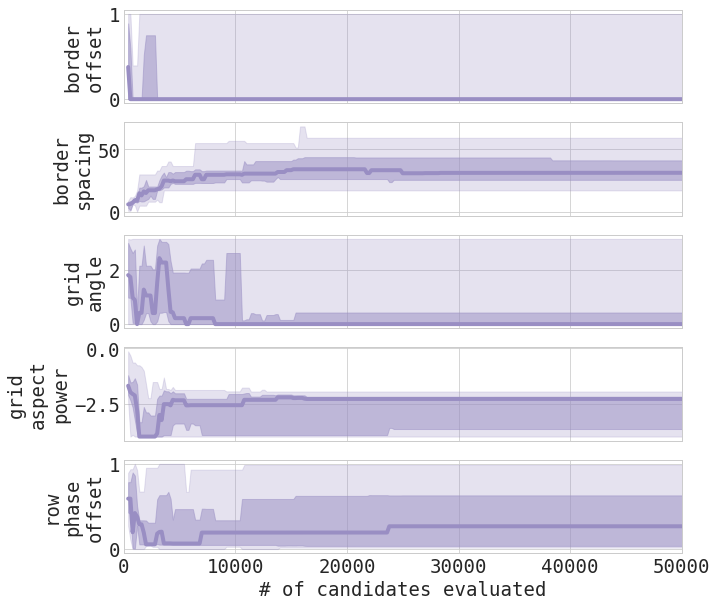

In [25]:
run_group = 'loc_1_site_irregular_method_CMAES_eval_50k'
aggregated_data_sets = make_aggregated_data_set(data_sets)
solution_vars = extract_solution_vars(data_sets)

solar_vars = [var for var in solution_vars if var.startswith('solar')]
wind_vars = [var for var in solution_vars if not var.startswith('solar')]

def plot_solution_vars(solution_vars):
    fig, axs = plt.subplots(len(solution_vars), sharex=True, figsize=[10,2*len(solution_vars)])
    for i, var in enumerate(solution_vars):
        col_name = 'best_solution.' + var
        ax = axs[i]
        ax.set_xlim(0, 50000)
        ax.set(ylabel=var.replace('_','\n'))
        run_data = aggregated_data_sets[run_group]
        x = run_data['num_evaluations'].median(1) + 200
        color = solar_color if var.startswith('solar') else wind_color
        plot_quantiles(ax, x, run_data[col_name], color=color)

    plt.xlabel('# of candidates evaluated')

plot_solution_vars(solar_vars)
plt.savefig(name + 'solution_trajectories_solar.svg')

plot_solution_vars(wind_vars)
plt.savefig(name + 'solution_trajectories_wind.svg')

Text(0.5, 0, 'num_evaluations')

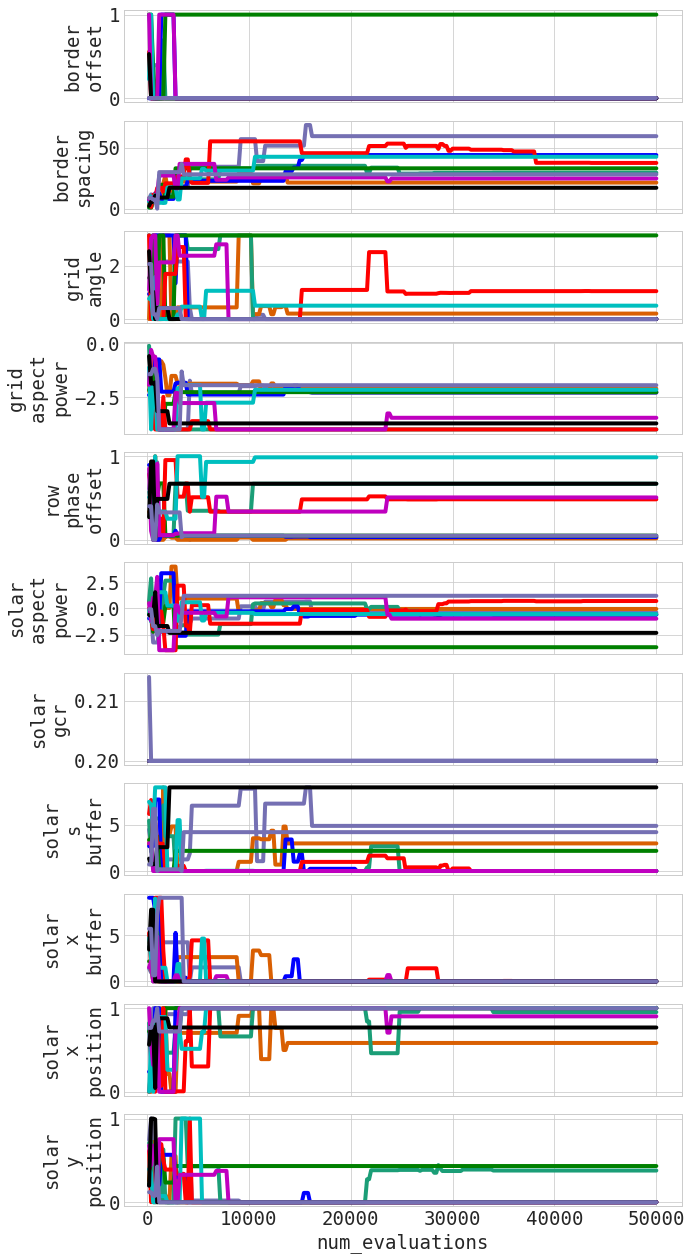

In [26]:
solution_vars = extract_solution_vars(data_sets)
fig, axs = plt.subplots(len(solution_vars), sharex=True, figsize=[10,2*len(solution_vars)])
for i, var in enumerate(solution_vars):
    col_name = 'best_solution.' + var
    ax = axs[i]
    ax.set(ylabel=var.replace('_','\n'))
    
#     for j, (run_group, group_data) in enumerate(aggregated_data_sets.items()):
    j = 0
    run_group = 'loc_1_site_irregular_method_CMAES_eval_50k'
#     run_group = 'site_irregular_method_CMAES_eval_20k'
#     run_group = 'site_circular_method_CMAES_eval_20k'
    group_data = aggregated_data_sets[run_group]
#     plot_quantiles(ax, group_data['num_evaluations'].median(1), group_data[col_name], color=(.5,.5,.5))
        
#     for run_group, runs in data_sets.items():
    runs = data_sets[run_group]
    for j, (run_name, data_set) in enumerate(runs.items()):
        vals = data_set[col_name]
        ax.plot(data_set['num_evaluations'], vals, color=colors[j%len(colors)])

    
plt.xlabel('num_evaluations')


ValueError: Invalid RGBA argument: 0.15

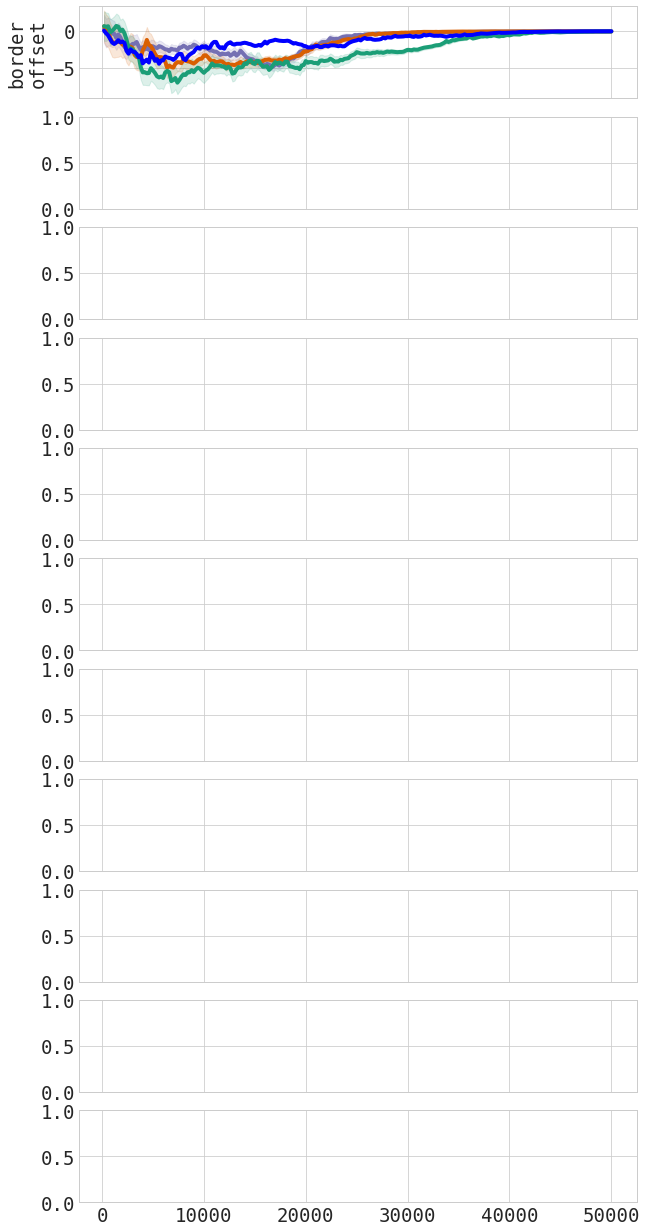

In [27]:
fig, axs = plt.subplots(len(solution_vars), sharex=True, figsize=[10,2*len(solution_vars)])
for i, var in enumerate(solution_vars):
    ax = axs[i]
    ax.set(ylabel=var.replace('_','\n'))
    
#     for j, (run_group, group_data) in enumerate(aggregated_data_sets.items()):
#         plot_quantiles(ax, group_data['num_evaluations'].median(1), group_data[col_name], color=(.5,.5,.5))
        
#     for run_group, runs in data_sets.items():
#     run_group = 'site_circular_method_CMAES_eval_20k'
#     run_group = 'site_irregular_method_CMAES_eval_20k'
    run_group = 'loc_1_site_irregular_method_CMAES_eval_50k'
    runs = data_sets[run_group]
    for j, (run_name, data_set) in enumerate(runs.items()):
#             ax.plot(x, aggregated_column.quantile(.5, 1), color=color)
#             q1 = aggregated_column.quantile(.5+value/2, 1).values.tolist()
#             q2 = aggregated_column.quantile(.5-value/2, 1).values.tolist()
#             ax.fill_between(x, q1, q2, color=(*color, alpha))
        color = colors[j%len(colors)]
        num_evaluations = data_set['num_evaluations']    
        mean = data_set['mean.'+var]
        stdev = np.sqrt(data_set['variance.'+var])
        ax.plot(num_evaluations, mean, color=color)
        ax.fill_between(num_evaluations, mean+stdev, mean-stdev, color=(*color, .15))
    
    
plt.xlabel('num_evaluations')


            

In [28]:
for j, (run_name, data_set) in enumerate(runs.items()):
    print(run_name,data_set['best_solution'][1])
    

2020-08-27T18.02.34.783080 {'border_spacing': 8.28021306311461, 'border_offset': 0.0, 'grid_angle': 3.141592653589793, 'grid_aspect_power': -1.4533955845569557, 'row_phase_offset': 0.609025104058747, 'solar_x_position': 0.7669138570677017, 'solar_y_position': 0.7430294143963787, 'solar_aspect_power': 0.6865805590431295, 'solar_gcr': 0.21398364704279915, 'solar_s_buffer': 4.45920086986227, 'solar_x_buffer': 1.4162260224722583}
2020-08-27T18.16.23.592215 {'border_spacing': 4.93804382345413, 'border_offset': 0.0, 'grid_angle': 0, 'grid_aspect_power': -2.2294885014938375, 'row_phase_offset': 0.33506428145961475, 'solar_x_position': 0.0, 'solar_y_position': 0.2511727146473098, 'solar_aspect_power': 0.658555940832374, 'solar_gcr': 0.2, 'solar_s_buffer': 2.815721220260018, 'solar_x_buffer': 4.18949931163647}
2020-08-27T18.02.34.782599 {'border_spacing': 0.8120064114619812, 'border_offset': 1.0, 'grid_angle': 3.141592653589793, 'grid_aspect_power': -0.13281588153523588, 'row_phase_offset': 0.5

make_inner_candidate_from_parameters penalty 24.2851998363086
[1106.5789473684217, -555.7260642530218, -494.7592890793785, -433.7925139057352, -372.82573873209003, -311.8589635584467, -2136.95975804556, -250.89218838480156, -2075.992982871917, -189.92541321115732, -2015.0262076982726, -128.958638037514, -1954.0594325246284, -67.99186286386885, -1893.092657350985, -7.025087690227338, -1832.12588217734, 53.94168748341781, -1771.1591070036966, 114.90846265706114, -1710.1923318300524, 175.87523783070628, -1649.225556656409, 236.84201300435052, -1588.2587814827639, 297.80878817799567, -1527.2920063091206, 358.775563351639, -1466.3252311354763, 419.7423385252823, -1405.358455961832, 480.70911369892656, -1344.3916807881888, 541.6758888725699, -1283.4249056145436, 602.642664046215, -1222.4581304409003, 663.6094392198584, -1161.491355267256, 724.5762143935035, -1100.5245800936118, 785.5429895671468, -1039.5578049199685, 846.5097647407902, -978.5910297463233, 907.4765399144353, -917.62425457268,

make_inner_candidate_from_parameters penalty 1.0547712323688598
[-2820.4558299597165, -281.63086036177106, 930.3537296154882, -790.6720368826172, 844.0403418176729, -876.9854246804325, 757.7269540198567, -963.2988124782487, 671.4135662220424, -1049.6122002760621, 585.100178424228, -1135.9255880738774, 498.78679062641186, -1222.2389758716936, 412.4734028285975, -1308.552363669508, 326.16001503078314, -1394.8657514673223, 239.84662723296697, -1481.1791392651385, 153.5332394351526, -1567.4925270629528, 67.21985163733643, -1653.805914860769, -19.093536160477925, -1740.1193026585834, -105.40692395829228, -1826.4326904563977, -191.72031175610846, -1912.746078254214, -278.0336995539228, -1999.0594660520283, -364.347087351739, -2085.3728538498444, -450.66047514955335, -2171.686241647659, -536.9738629473695, -2257.999629445475, -623.2872507451839, -2344.3130172432893, -709.6006385429982, -2430.6264050411037, -1141.1675775320737, -1227.4809653298898, -1313.7943531277042, -1400.1077409255186, 148

make_inner_candidate_from_parameters penalty 86.29230399964561
[1106.5789473684217, 440.03715579743744, -1453.0390725090242, -2411.5213663959944, -1026.045967103977, -981.3101833082346, -936.5743995125067, -891.8386157167643, -847.1028319210218, -2014.757705276952, -802.3670481252793, -1970.0219214812387, -757.6312643295378, -1925.2861376854962, -712.8954805337944, -1880.5503538897538, -3048.205227245684, -668.1596967380519, -1835.8145700940113, -3003.4694434499415, -623.4239129423386, -1791.0787862982688, 588.9667442093632, -578.6881291465961, -1746.3430025025264, 633.7025280050766, -533.9523453508536, -1701.607218706784, 678.4383118008191, -489.2165615551112, -1656.8714349110414, 723.1740955965615, -444.4807777593678, -1612.135651115299, 767.909879392304, -399.74499396362535, -1567.3998673195856, 812.6456631880465, -355.0092101678847, -1522.6640835238431, 857.3814469837889, -310.27342637217134, -1477.9282997281007, 902.1172307795314, -265.53764257642797, 946.8530145752738, -220.80185

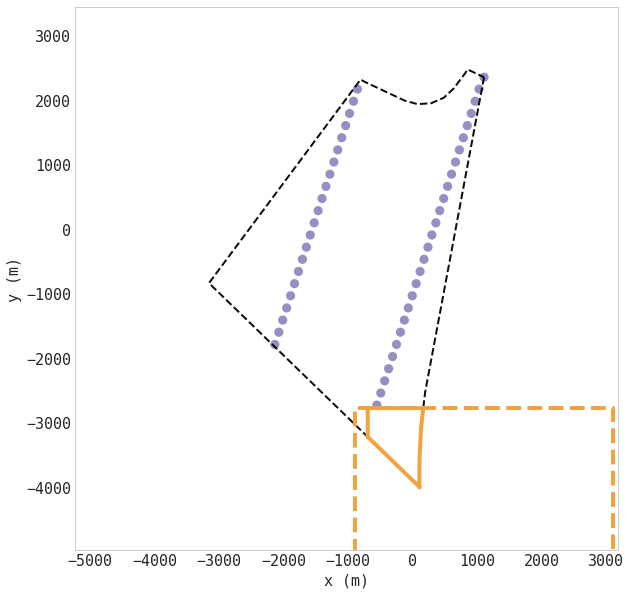

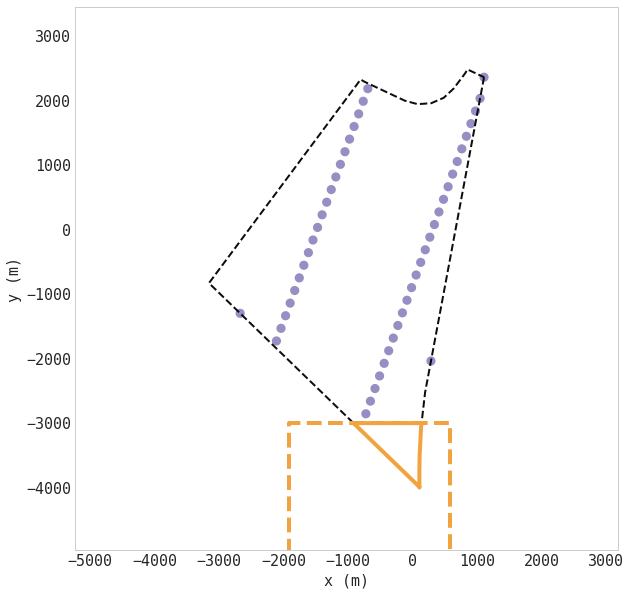

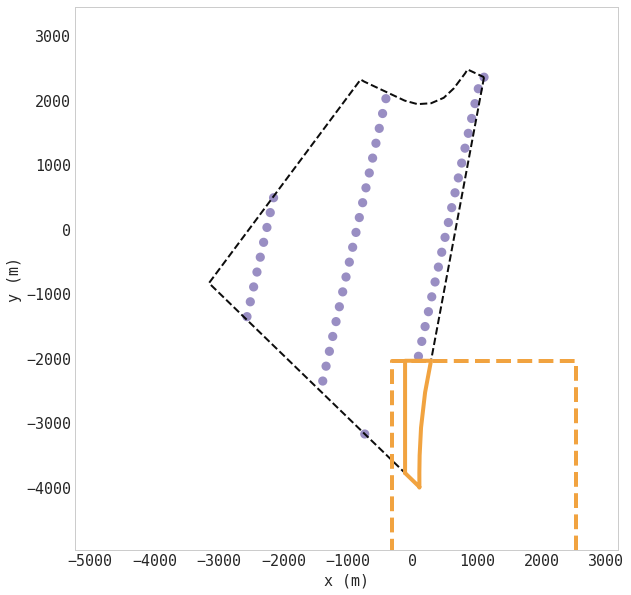

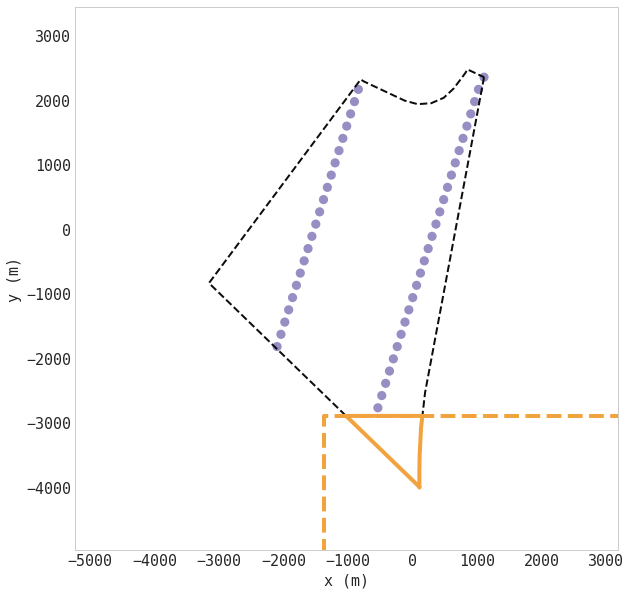

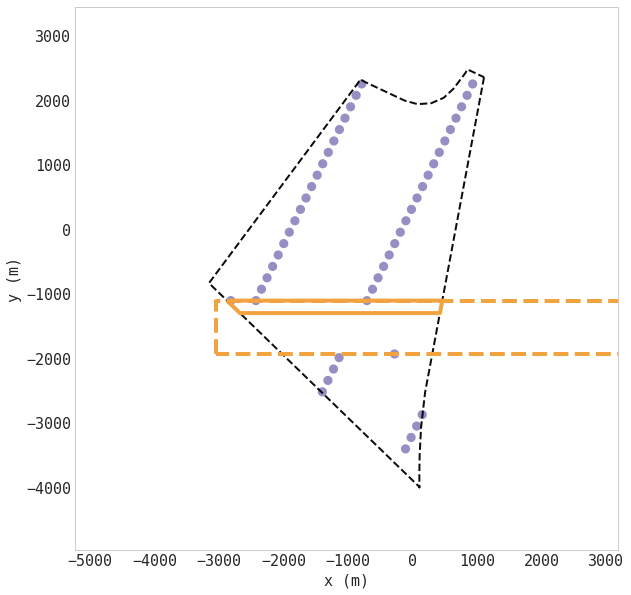

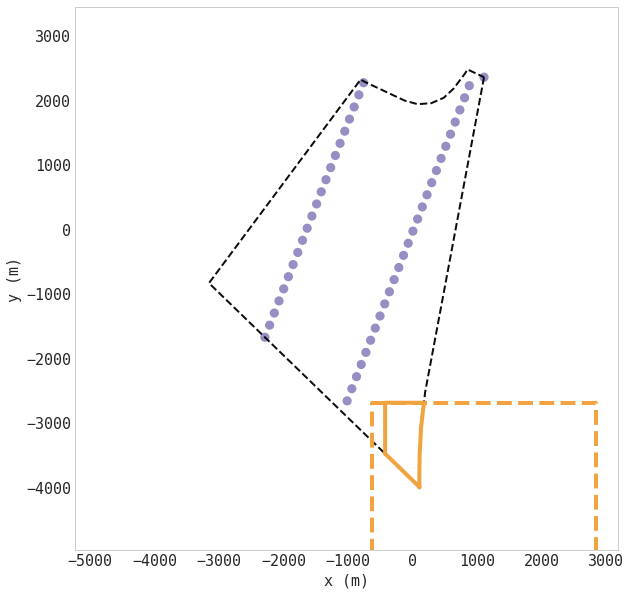

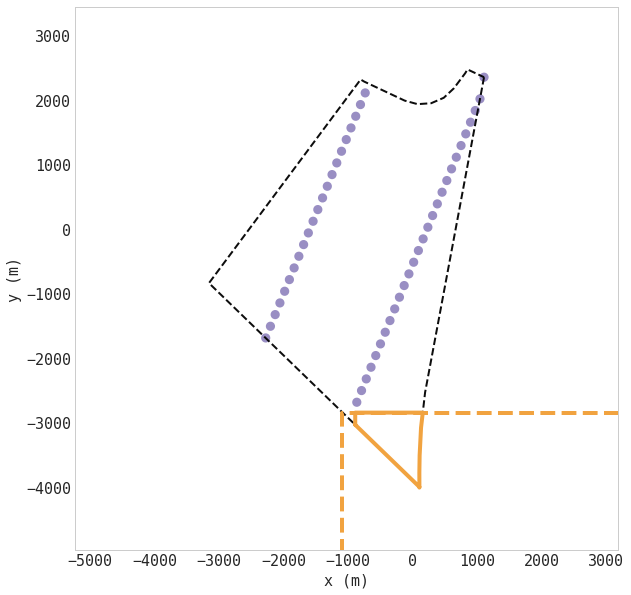

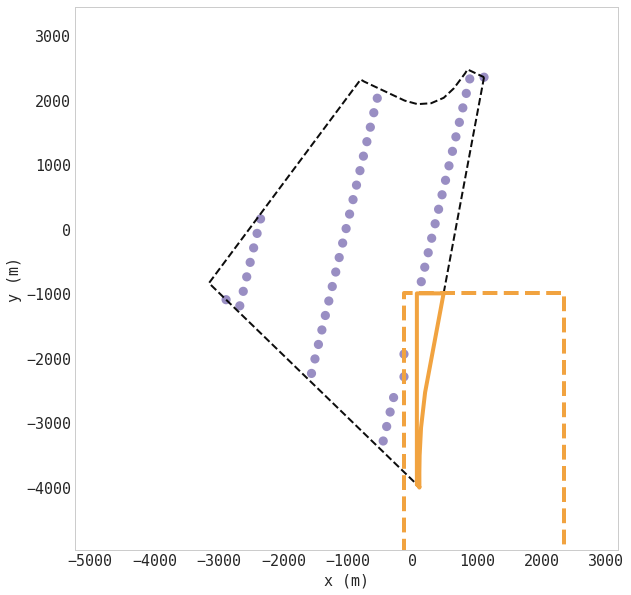

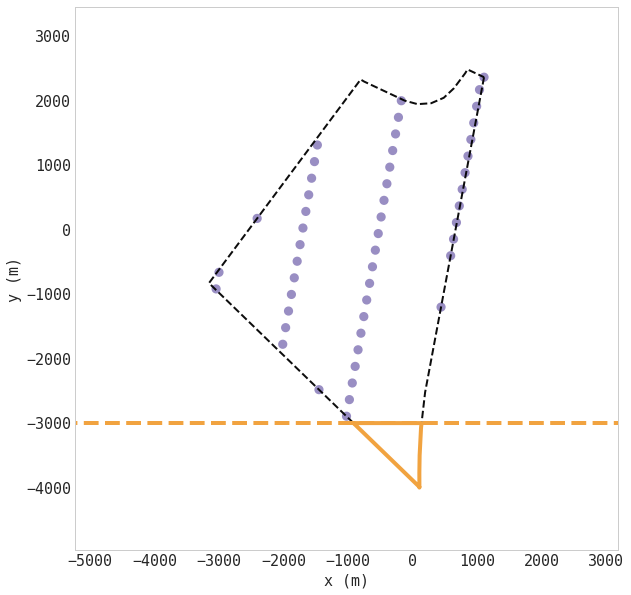

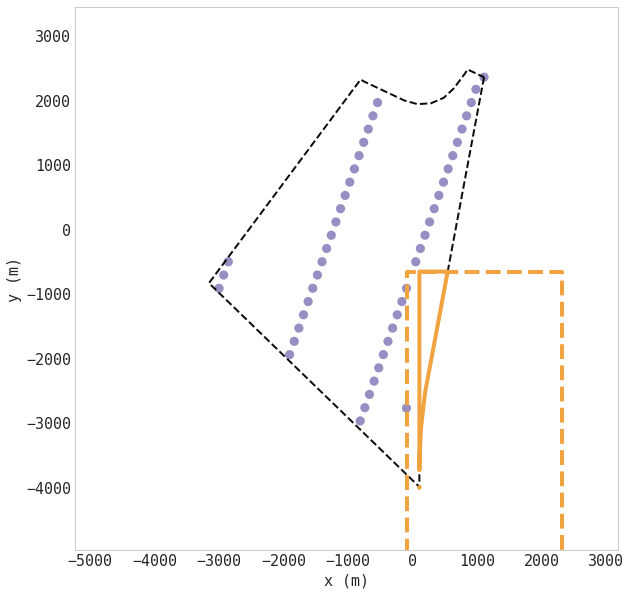

In [30]:

# site_data, config_file_name

config = {}
with open(config_file_name) as f:
  config = json.load(f)

site_info = SiteInfo(site_data)
inner_problem = HybridOptimizationProblem(site_info, config['num_turbines'], config['solar_capacity'])
problem = HybridParametrization(inner_problem)

wind_color = (153 / 255, 142 / 255, 195 / 255)
solar_color = (241 / 255, 163 / 255, 64 / 255)
border_color = (0, 0, 0)

bounds = problem.inner_problem.site_info.polygon.bounds
site_sw_bound = np.array([bounds[0], bounds[1]])
site_ne_bound = np.array([bounds[2], bounds[3]])
site_center = .5 * (site_sw_bound + site_ne_bound)
max_delta = max(bounds[2] - bounds[0], bounds[3] - bounds[1])
reach = (max_delta / 2) * 1.3
min_plot_bound = site_center - reach
max_plot_bound = site_center + reach
    
ds = None
for j, (run_name, data_set) in enumerate(runs.items()):
    
#     print(run_name)
    ds = data_set
    
    j_candidate = data_set.at[100, 'best_solution']
#     j_candidate = data_set.at[1, 'best_solution']
#     print(run_name, j_candidate)
    candidate = HybridCandidate(**j_candidate)
#     print(run_name, candidate)
#     candidate = data_set[data_set.iteration==1,'best_solution'].values[0]
    
    figure = plt.figure(figsize=(10,10))
    axes = figure.add_subplot(111)
    axes.cla()
    axes.set(xlim=(min_plot_bound[0], max_plot_bound[0]), ylim=(min_plot_bound[1], max_plot_bound[1]))
    axes.set_aspect('equal')
    plt.grid()
    plt.tick_params(which='both', labelsize=15)
    plt.xlabel('x (m)', fontsize=15)
    plt.ylabel('y (m)', fontsize=15)
    problem.plot_candidate(candidate, figure, axes, wind_color, solar_color, border_color, alpha=1.0)
